# Entrenamiento internet

In [1]:
import os

# Dataset
SOURCE_LANGUAGE = "en"
TARGET_LANGUAGE = "es"
SUBSET = False
PERCENT_SUBSET = 0.1

# Train
LR = 1e-5
EPOCHS = 100000
GPUS = 1
GPU_NUMBER = 0
if GPUS > 1:
    BS = 56
else:
    if SUBSET:
        BS = 128
    else:
        BS = 1024
print(f"BS: {BS}")
LR_SCHEDULER = False
SAVE_BEST_MODEL = False
STOP_AT_TIME = False

# Model
MODEL_PATH = f"model"
if os.path.exists(MODEL_PATH):
    files = os.listdir(MODEL_PATH)
    model_files = [file for file in files if "transformer" in file]
    if len(model_files) > 0:
        name = model_files[0].split(".")[0]
        STEP0 = int(name.split("_")[-1])
        EPOCH0 = int(name.split("_")[-2])
    else:
        EPOCH0 = 0
        STEP0 = 0
else:
    EPOCH0 = 0
    STEP0 = 0
print(f"EPOCH0: {EPOCH0}, STEP0: {STEP0}")
DIM_EMBEDDING = 512
NUM_HEADS = 8
NUM_LAYERS = 6
DROPOUT = 0.1
LABEL_SMOOTHING = 0.1

# Tokenizers
TOKENIZERS_PATH = f"tokenizers"
if not os.path.exists(TOKENIZERS_PATH):
    os.makedirs(TOKENIZERS_PATH)
UNKNOWN_TOKEN = "[UNK]"
PADDING_TOKEN = "[PAD]"
START_OF_SEQUENCE = "[SOS]"
END_OF_SEQUENCE = "[EOS]"

BS: 1024
EPOCH0: 0, STEP0: 0


In [2]:
# TODOs
# TODO: Podar el transformer
# TODO: Ajustar bien los parámetros del LR scheduler
# TODO: Añadir enlace a colab

## Carga de los datos ✔

Cargamos el dataset

In [3]:
from datasets import load_from_disk

path_train = "data/opus100_train_croped_3_20"
path_val = "data/opus100_val_croped_3_20"
path_test = "data/opus100_test_croped_3_20"

dataset_raw_train = load_from_disk(path_train)
dataset_raw_val = load_from_disk(path_val)
dataset_raw_test = load_from_disk(path_test)

if SUBSET:
    len_dataset_train = len(dataset_raw_train)
    len_dataset_val = len(dataset_raw_val)
    len_dataset_test = len(dataset_raw_test)
    len_subset_train = int(len_dataset_train * PERCENT_SUBSET)
    len_subset_val = int(len_dataset_val * PERCENT_SUBSET)
    len_subset_test = int(len_dataset_test * PERCENT_SUBSET)
    dataset_raw_train = dataset_raw_train.select(range(len_subset_train))
    dataset_raw_val = dataset_raw_val.select(range(len_subset_val))
    dataset_raw_test = dataset_raw_test.select(range(len_subset_test))

len(dataset_raw_train), len(dataset_raw_val), len(dataset_raw_test)

(728561, 1458, 1444)

Vamos a ver cómo es el dataset

In [4]:
dataset_raw_train

Dataset({
    features: ['translation'],
    num_rows: 728561
})

Vemos que es un objeto con 1000000 de filas y una `feature` llamada `translation`

Vamos a ver la feature `translation`

In [5]:
dataset_raw_train['translation']

[{'en': "It was the asbestos in here, that's what did it!",
  'es': 'Fueron los asbestos aquí. ¡Eso es lo que ocurrió!'},
 {'en': "I'm out of here.", 'es': 'Me voy de aquí.'},
 {'en': 'One time, I swear I pooped out a stick of chalk.',
  'es': 'Una vez, juro que cagué una barra de tiza.'},
 {'en': 'And I will move, do you understand me?',
  'es': 'Y prefiero mudarme, ¿Entiendes?'},
 {'en': '- Thank you, my lord.', 'es': '- Gracias.'},
 {'en': 'You have to help me.', 'es': 'Debes ayudarme.'},
 {'en': 'Fuck this!', 'es': '¡Por la mierda!'},
 {'en': 'The safety and efficacy of MIRCERA therapy in other indications has not been established.',
  'es': 'No se ha establecido la seguridad y eficacia del tratamiento con MIRCERA en otras indicaciones.'},
 {'en': 'You can stay if you want.',
  'es': 'Así lo decidí, pueden quedarse si quieren.'},
 {'en': "- I'm not stupid.", 'es': '- Yo no soy estúpido.'},
 {'en': 'Sorry, a weird gas bubble for a sec.',
  'es': 'Perdón, he tenido una burbuja de gas

Vemos que es una lista, vamos a ver el primer elemento

In [6]:
dataset_raw_train[0]['translation']

{'en': "It was the asbestos in here, that's what did it!",
 'es': 'Fueron los asbestos aquí. ¡Eso es lo que ocurrió!'}

Vemos que es un diccionario con la frase en el idioma original y la traducción

Vamos a ver una frase en cada idioma

In [7]:
dataset_raw_train[0]['translation'][SOURCE_LANGUAGE]

"It was the asbestos in here, that's what did it!"

In [8]:
dataset_raw_train[0]['translation'][TARGET_LANGUAGE]

'Fueron los asbestos aquí. ¡Eso es lo que ocurrió!'

## Device ✔

In [9]:
import torch

if torch.cuda.device_count() > 1 and GPUS > 1:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using {torch.cuda.device_count()} GPUs")
else:
    if torch.cuda.is_available():
        device = torch.device(f"cuda:{GPU_NUMBER}")
        print(f"Using GPU {GPU_NUMBER}")
    else:
        device = torch.device("cpu")
        print("Using CPU")

Using GPU 0


## Entrenamiento de los tokenizers ✔

Vamos a entrenar un tokenizer para cada idioma. Podríamos utilizar uno ya preentrenado, pero a veces entrenar uno propio puede dar mejores resultados.

In [10]:
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.pre_tokenizers import Whitespace

In [11]:
import tqdm

def get_all_sentences(dataset, languaje):
    all_sentences = []
    bar = tqdm.tqdm(range(len(dataset)))
    for i in bar:
        all_sentences.append(dataset[i]['translation'][languaje])
    return all_sentences

Entrenamos el tokenizer para el idioma original

In [12]:
tokenizer_source_path = f"{TOKENIZERS_PATH}/tokenizer_{SOURCE_LANGUAGE}.json"

if not os.path.exists(tokenizer_source_path):
    print(f"Training source tokenizer")
    tokenizer_source = Tokenizer(WordLevel(unk_token=UNKNOWN_TOKEN))
    tokenizer_source.pre_tokenizer = Whitespace()
    trainer = WordLevelTrainer(special_tokens=[UNKNOWN_TOKEN, PADDING_TOKEN, START_OF_SEQUENCE, END_OF_SEQUENCE])
    all_sentences = get_all_sentences(dataset_raw_train, SOURCE_LANGUAGE)
    tokenizer_source.train_from_iterator(all_sentences, trainer)
    tokenizer_source.save(tokenizer_source_path)
else:
    print(f"Loading source tokenizer from {tokenizer_source_path}")
    tokenizer_source = Tokenizer.from_file(tokenizer_source_path)

Loading source tokenizer from tokenizers/tokenizer_en.json


Vamos a ver cómo es el tokenizer

In [13]:
with open(tokenizer_source_path, 'r') as file:
    for i in range(100):
        line = file.readline()
        if line == "\n":
            continue
        print(line, end="")

{
  "version": "1.0",
  "truncation": null,
  "padding": null,
  "added_tokens": [
    {
      "id": 0,
      "content": "[UNK]",
      "single_word": false,
      "lstrip": false,
      "rstrip": false,
      "normalized": false,
      "special": true
    },
    {
      "id": 1,
      "content": "[PAD]",
      "single_word": false,
      "lstrip": false,
      "rstrip": false,
      "normalized": false,
      "special": true
    },
    {
      "id": 2,
      "content": "[SOS]",
      "single_word": false,
      "lstrip": false,
      "rstrip": false,
      "normalized": false,
      "special": true
    },
    {
      "id": 3,
      "content": "[EOS]",
      "single_word": false,
      "lstrip": false,
      "rstrip": false,
      "normalized": false,
      "special": true
    }
  ],
  "normalizer": null,
  "pre_tokenizer": {
    "type": "Whitespace"
  },
  "post_processor": null,
  "decoder": null,
  "model": {
    "type": "WordLevel",
    "vocab": {
      "[UNK]": 0,
      "[PAD]": 1

Entrenamos el tokenizer para el idioma traducido

In [14]:
tokenizer_target_path = f"{TOKENIZERS_PATH}/tokenizer_{TARGET_LANGUAGE}.json"

if not os.path.exists(tokenizer_target_path):
    print(f"Training target tokenizer")
    tokenizer_target = Tokenizer(WordLevel(unk_token=UNKNOWN_TOKEN))
    tokenizer_target.pre_tokenizer = Whitespace()
    trainer = WordLevelTrainer(special_tokens=[UNKNOWN_TOKEN, PADDING_TOKEN, START_OF_SEQUENCE, END_OF_SEQUENCE])
    all_sentences = get_all_sentences(dataset_raw_train)
    tokenizer_target.train_from_iterator(all_sentences, trainer)
    tokenizer_target.save(tokenizer_target_path)
else:
    print(f"Loading target tokenizer from {tokenizer_target_path}")
    tokenizer_target = Tokenizer.from_file(tokenizer_target_path)

Loading target tokenizer from tokenizers/tokenizer_es.json


Vamos a ver cómo es el tokenizer

In [15]:
with open(tokenizer_target_path, 'r') as file:
    for i in range(100):
        line = file.readline()
        if line == "\n":
            continue
        print(line, end="")

{
  "version": "1.0",
  "truncation": null,
  "padding": null,
  "added_tokens": [
    {
      "id": 0,
      "content": "[UNK]",
      "single_word": false,
      "lstrip": false,
      "rstrip": false,
      "normalized": false,
      "special": true
    },
    {
      "id": 1,
      "content": "[PAD]",
      "single_word": false,
      "lstrip": false,
      "rstrip": false,
      "normalized": false,
      "special": true
    },
    {
      "id": 2,
      "content": "[SOS]",
      "single_word": false,
      "lstrip": false,
      "rstrip": false,
      "normalized": false,
      "special": true
    },
    {
      "id": 3,
      "content": "[EOS]",
      "single_word": false,
      "lstrip": false,
      "rstrip": false,
      "normalized": false,
      "special": true
    }
  ],
  "normalizer": null,
  "pre_tokenizer": {
    "type": "Whitespace"
  },
  "post_processor": null,
  "decoder": null,
  "model": {
    "type": "WordLevel",
    "vocab": {
      "[UNK]": 0,
      "[PAD]": 1

## Obtención de la lóngitud máxima de las secuencias ✔

In [16]:
max_source_sequence_length = 0
max_target_sequence_length = 0

for i in range(len(dataset_raw_train)):
    source_sequence_length = len(tokenizer_source.encode(dataset_raw_train[i]['translation'][SOURCE_LANGUAGE]).ids)
    target_sequence_length = len(tokenizer_target.encode(dataset_raw_train[i]['translation'][TARGET_LANGUAGE]).ids)
    if source_sequence_length > max_source_sequence_length:
        max_source_sequence_length = source_sequence_length
    if target_sequence_length > max_target_sequence_length:
        max_target_sequence_length = target_sequence_length

max_sequence_len = max(max_source_sequence_length, max_target_sequence_length)
max_sequence_len += 2   # Add 2 for the start and end of sequence tokens

print(f"Max source sequence length: {max_source_sequence_length}")
print(f"Max target sequence length: {max_target_sequence_length}")
print(f"Max sequence length: {max_sequence_len}")

Max source sequence length: 20
Max target sequence length: 20
Max sequence length: 22


## Datasets ✔

### Mask ✔

In [17]:
def create_mask(sequence_len):
    if GPUS > 1:
        mask = torch.tril(torch.ones((torch.cuda.device_count(), sequence_len, sequence_len)))
    else:
        mask = torch.tril(torch.ones((1, sequence_len, sequence_len)))
    return mask

### Dataset class ✔

In [18]:
import torch
from torch.utils.data import Dataset

class BilingualDataset(Dataset):
    def __init__(self, dataset, tokenizer_src, tokenizer_tgt, src_lang, tgt_lang, max_seq_len) -> None:
        super().__init__()
        
        self.max_seq_len = max_seq_len
        self.dataset = dataset
        self.tokenizer_src = tokenizer_src
        self.tokenizer_tgt = tokenizer_tgt
        self.src_lang = src_lang
        self.tgt_lang = tgt_lang
        
        # Defining special tokens by using the target language tokenizer
        self.sos_token = torch.tensor([tokenizer_tgt.token_to_id(START_OF_SEQUENCE)], dtype=torch.int64)
        self.eos_token = torch.tensor([tokenizer_tgt.token_to_id(END_OF_SEQUENCE)], dtype=torch.int64)
        self.pad_token = torch.tensor([tokenizer_tgt.token_to_id(PADDING_TOKEN)], dtype=torch.int64)
        self.unk_token = torch.tensor([tokenizer_tgt.token_to_id(UNKNOWN_TOKEN)], dtype=torch.int64)
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, index):
        # Getting the source and target texts from the dataset
        src_target_pair = self.dataset[index]['translation']
        src_text = src_target_pair[self.src_lang]
        tgt_text = src_target_pair[self.tgt_lang]
        
        # Tokenizing source and target texts 
        encoder_input_tokens = self.tokenizer_src.encode(src_text).ids
        decoder_input_tokens = self.tokenizer_tgt.encode(tgt_text).ids
        
        # Computing how many padding tokens need to be added to the tokenized texts 
        encoder_num_padding_tokens = self.max_seq_len - len(encoder_input_tokens) - 2 # Subtracting the two '[EOS]' and '[SOS]' special tokens
        decoder_num_padding_tokens = self.max_seq_len - len(decoder_input_tokens) - 1 # Subtracting the '[SOS]' special token
        
        # If the texts exceed the 'seq_len' allowed, it will raise an error. This means that one of the sentences in the pair is too long to be processed
        # given the current sequence length limit (this will be defined in the config dictionary below)
        if encoder_num_padding_tokens < 0 or decoder_num_padding_tokens < 0:
            raise ValueError('Sentence is too long')
         
        # Building the encoder input tensor by combining several elements
        encoder_input = torch.cat(
            [
                self.sos_token, # inserting the '[SOS]' token
                torch.tensor(encoder_input_tokens, dtype = torch.int64), # Inserting the tokenized source text
                self.eos_token, # Inserting the '[EOS]' token
                torch.tensor([self.pad_token] * encoder_num_padding_tokens, dtype = torch.int64) # Addind padding tokens
            ]
        )
        
        # Building the decoder input tensor by combining several elements
        decoder_input = torch.cat(
            [
                self.sos_token, # inserting the '[SOS]' token 
                torch.tensor(decoder_input_tokens, dtype = torch.int64), # Inserting the tokenized target text
                torch.tensor([self.pad_token] * decoder_num_padding_tokens, dtype = torch.int64) # Addind padding tokens
            ]
        )
        
        # Creating a label tensor, the expected output for training the model
        label = torch.cat(
            [
                torch.tensor(decoder_input_tokens, dtype = torch.int64), # Inserting the tokenized target text
                self.eos_token, # Inserting the '[EOS]' token 
                torch.tensor([self.pad_token] * decoder_num_padding_tokens, dtype = torch.int64) # Adding padding tokens
            ]
        )
        
        # Ensuring that the length of each tensor above is equal to the defined 'seq_len'
        assert encoder_input.size(0) == self.max_seq_len
        assert decoder_input.size(0) == self.max_seq_len
        assert label.size(0) == self.max_seq_len

        return {
            'encoder_input': encoder_input,
            'decoder_input': decoder_input, 
            'label': label,
            'src_text': src_text,
            'tgt_text': tgt_text
        }


Veamos una muestra

In [19]:
from random import randint

sample_dataset = BilingualDataset(dataset_raw_train, tokenizer_source, tokenizer_target, SOURCE_LANGUAGE, TARGET_LANGUAGE, max_sequence_len)
idx = randint(0, len(sample_dataset))
sample_dataset = sample_dataset[idx]

print(f"Encoder input shape: {sample_dataset['encoder_input'].shape}")
print(f"Decoder input shape: {sample_dataset['decoder_input'].shape}")
print(f"Label shape: {sample_dataset['label'].shape}")
print(f"Source text: {sample_dataset['src_text']}")
print(f"Target text: {sample_dataset['tgt_text']}")

Encoder input shape: torch.Size([22])
Decoder input shape: torch.Size([22])
Label shape: torch.Size([22])
Source text: You remember this? Huh? Get out of the car!
Target text: ¿Recuerdas esto? ¡Sal del coche!


### Split dataset ✔

Ahora que vemos que está bien, creamos los datasets de entrenamiento y validación

In [20]:
print(f"Len train: {len(dataset_raw_train)}, len validation: {len(dataset_raw_val)}, len test: {len(dataset_raw_test)}")

Len train: 728561, len validation: 1458, len test: 1444


In [21]:
train_dataset = BilingualDataset(dataset_raw_train, tokenizer_source, tokenizer_target, SOURCE_LANGUAGE, TARGET_LANGUAGE, max_sequence_len)
validation_dataset = BilingualDataset(dataset_raw_val, tokenizer_source, tokenizer_target, SOURCE_LANGUAGE, TARGET_LANGUAGE, max_sequence_len)
test_dataset = BilingualDataset(dataset_raw_test, tokenizer_source, tokenizer_target, SOURCE_LANGUAGE, TARGET_LANGUAGE, max_sequence_len)

## Dataloaders ✔

In [22]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=BS, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=BS, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BS, shuffle=False)

Vamos a ver una muestra

In [23]:
batch = next(iter(train_dataloader))
type(batch)

dict

Como vemos la muestra es un diccionario, vamos a ver sus claves

In [24]:
batch.keys()

dict_keys(['encoder_input', 'decoder_input', 'label', 'src_text', 'tgt_text'])

Las claves son las salidas que habíamos definido en el dataset. Vamos a ver ahora cómo es cada una de las claves

In [25]:
batch['encoder_input'].shape, batch['decoder_input'].shape, batch['label'].shape, len(batch['src_text']), len(batch['tgt_text'])

(torch.Size([1024, 22]),
 torch.Size([1024, 22]),
 torch.Size([1024, 22]),
 1024,
 1024)

Cada una de las claves tiene tantas muestras como hemos definido en el batch size (`BS`). Vamos ahora a ver una de las muestras

In [26]:
idx = randint(0, BS)

print(f"Encoder input shape: {batch['encoder_input'][idx].shape}")
print(f"Decoder input shape: {batch['decoder_input'][idx].shape}")
print(f"Label shape: {batch['label'][idx].shape}")
print(f"Source text: {batch['src_text'][idx]}")
print(f"Target text: {batch['tgt_text'][idx]}")

Encoder input shape: torch.Size([22])
Decoder input shape: torch.Size([22])
Label shape: torch.Size([22])
Source text: Okay, I've been saying they're all in bed together.
Target text: Ya te lo dije. Todos están involucrados en esto.


## Modelo ✔

Volvemos a escribir todo el código del transformer y creamos un objeto de este

### Clases de bajo nivel

In [27]:
import torch
import torch.nn as nn
import torch.nn.init as init

class CustomLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super(CustomLinear, self).__init__()
        self.linear = nn.Linear(in_features, out_features)
        init.kaiming_uniform_(self.linear.weight, nonlinearity='relu')
        if self.linear.bias is not None:
            init.zeros_(self.linear.bias)
    
    def forward(self, x):
        return self.linear(x)

class CustomEmbedding(nn.Module):
    def __init__(self, num_embeddings, embedding_dim):
        super(CustomEmbedding, self).__init__()
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        init.xavier_uniform_(self.embedding.weight)
    
    def forward(self, x):
        return self.embedding(x)

class Embedding(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim

        self.embedding = CustomEmbedding(vocab_size, embedding_dim)

    def forward(self, x):
        return self.embedding(x)

class PositionalEncoding(nn.Module):
    def __init__(self, max_sequence_len, embedding_model_dim):
        super().__init__()
        self.embedding_dim = embedding_model_dim
        positional_encoding = torch.zeros(max_sequence_len, self.embedding_dim)
        for pos in range(max_sequence_len):
            for i in range(0, self.embedding_dim, 2):
                positional_encoding[pos, i]     = torch.sin(torch.tensor(pos / (10000 ** ((2 * i) / self.embedding_dim))))
                positional_encoding[pos, i + 1] = torch.cos(torch.tensor(pos / (10000 ** ((2 * (i+1)) / self.embedding_dim))))
        positional_encoding = positional_encoding.unsqueeze(0)
        self.register_buffer('positional_encoding', positional_encoding)

    def forward(self, x):
        x = x * torch.sqrt(torch.tensor(self.embedding_dim))
        sequence_len = x.size(1)
        x = x + self.positional_encoding[:,:sequence_len]
        return x

class ScaledDotProductAttention(nn.Module):
    def __init__(self, dim_embedding):
        super().__init__()
        self.dim_embedding = dim_embedding
    
    def forward(self, query, key, value, mask=None):
        key_trasposed = key.transpose(-1,-2)
        product = torch.matmul(query, key_trasposed)
        scale = product / torch.sqrt(torch.tensor(self.dim_embedding))
        if mask is not None:
            scale = scale.masked_fill(mask == 0, float('-inf'))
        attention_matrix = torch.softmax(scale, dim=-1)
        output = torch.matmul(attention_matrix, value)
        return output

class MultiHeadAttention(nn.Module):
    def __init__(self, heads, dim_embedding):
        super().__init__()
        
        self.dim_embedding = dim_embedding
        self.dim_proyection = dim_embedding // heads
        self.heads = heads
        self.proyection_Q = CustomLinear(dim_embedding, dim_embedding)
        self.proyection_K = CustomLinear(dim_embedding, dim_embedding)
        self.proyection_V = CustomLinear(dim_embedding, dim_embedding)
        self.attention = CustomLinear(dim_embedding, dim_embedding)
        self.scaled_dot_product_attention = ScaledDotProductAttention(self.dim_proyection)
    
    def forward(self, Q, K, V, mask=None):
        batch_size = Q.size(0)
        proyection_Q = self.proyection_Q(Q).view(batch_size, -1, self.heads, self.dim_proyection)
        proyection_K = self.proyection_K(K).view(batch_size, -1, self.heads, self.dim_proyection)
        proyection_V = self.proyection_V(V).view(batch_size, -1, self.heads, self.dim_proyection)
        proyection_Q = proyection_Q.transpose(1,2)
        proyection_K = proyection_K.transpose(1,2)
        proyection_V = proyection_V.transpose(1,2)
        scaled_dot_product_attention = self.scaled_dot_product_attention(proyection_Q, proyection_K, proyection_V, mask=mask)
        concat = scaled_dot_product_attention.transpose(1,2).contiguous().view(batch_size, -1, self.dim_embedding)
        output = self.attention(concat)
        return output

class AddAndNorm(nn.Module):
    def __init__(self, dim_embedding):
        super().__init__()
        self.normalization = nn.LayerNorm(dim_embedding)

    def forward(self, x, sublayer):
        return self.normalization(torch.add(x, sublayer))

class FeedForward(nn.Module):
    def __init__(self, dim_embedding, increment=4):
        super().__init__()
        self.feed_forward = nn.Sequential(
            CustomLinear(dim_embedding, dim_embedding*increment),
            nn.ReLU(),
            CustomLinear(dim_embedding*increment, dim_embedding)
        )
    
    def forward(self, x):
        x = self.feed_forward(x)
        return x

class Linear(nn.Module):
    def __init__(self, dim_embedding, vocab_size):
        super().__init__()
        self.linear = CustomLinear(dim_embedding, vocab_size)
        
    def forward(self, x):
        x = self.linear(x)
        return x

class Softmax(nn.Module):
    def __init__(self):
        super().__init__()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.softmax(x)
        return x

class Dropout(torch.nn.Module):
    def __init__(self, p=0.1):
        super().__init__()
        self.p = p

    def forward(self, x):
        if self.training:
            return torch.nn.functional.dropout(x, p=self.p)
        else:
            return x


### Clases de medio nivel

In [28]:
class EncoderLayer(nn.Module):
    def __init__(self, heads, dim_embedding, prob_dropout=0.1):
        super().__init__()
        self.multi_head_attention = MultiHeadAttention(heads, dim_embedding)
        self.dropout_1 = Dropout(prob_dropout)
        self.add_and_norm_1 = AddAndNorm(dim_embedding)
        self.feed_forward = FeedForward(dim_embedding)
        self.dropout_2 = Dropout(prob_dropout)
        self.add_and_norm_2 = AddAndNorm(dim_embedding)
    
    def forward(self, x):
        multi_head_attention = self.multi_head_attention(x, x, x)
        dropout1 = self.dropout_1(multi_head_attention)
        add_and_norm_1 = self.add_and_norm_1(x, dropout1)
        feed_forward = self.feed_forward(add_and_norm_1)
        dropout2 = self.dropout_2(feed_forward)
        add_and_norm_2 = self.add_and_norm_2(add_and_norm_1, dropout2)
        return add_and_norm_2

class Encoder(nn.Module):
    def __init__(self, heads, dim_embedding, Nx, prob_dropout=0.1):
        super().__init__()
        self.encoder_layers = nn.ModuleList([EncoderLayer(heads, dim_embedding, prob_dropout) for _ in range(Nx)])
    
    def forward(self, x):
        for encoder_layer in self.encoder_layers:
            x = encoder_layer(x)
        return x

class TransformerEncoder(nn.Module):
    def __init__(self, vocab_size, dim_embedding, max_sequence_len, heads, Nx, prob_dropout=0.1):
        super().__init__()
        self.input_embedding = Embedding(vocab_size, dim_embedding)
        self.positional_encoding = PositionalEncoding(max_sequence_len, dim_embedding)
        self.encoder = Encoder(heads, dim_embedding, Nx, prob_dropout)
    
    def forward(self, x):
        input_embedding = self.input_embedding(x)
        positional_encoding = self.positional_encoding(input_embedding)
        encoder = self.encoder(positional_encoding)
        return encoder

class DecoderLayer(nn.Module):
    def __init__(self, heads, dim_embedding, prob_dropout=0.1):
        super().__init__()
        self.masked_multi_head_attention = MultiHeadAttention(heads, dim_embedding)
        self.dropout_1 = Dropout(prob_dropout)
        self.add_and_norm_1 = AddAndNorm(dim_embedding)
        self.encoder_decoder_multi_head_attention = MultiHeadAttention(heads, dim_embedding)
        self.dropout_2 = Dropout(prob_dropout)
        self.add_and_norm_2 = AddAndNorm(dim_embedding)
        self.feed_forward = FeedForward(dim_embedding)
        self.dropout_3 = Dropout(prob_dropout)
        self.add_and_norm_3 = AddAndNorm(dim_embedding)
    
    def forward(self, x, encoder_output, mask=None):
        Q = x
        K = x
        V = x
        masked_multi_head_attention = self.masked_multi_head_attention(Q, K, V, mask=mask)
        dropout1 = self.dropout_1(masked_multi_head_attention)
        add_and_norm_1 = self.add_and_norm_1(dropout1, x)

        Q = add_and_norm_1
        K = encoder_output
        V = encoder_output
        encoder_decoder_multi_head_attention = self.encoder_decoder_multi_head_attention(Q, K, V)
        dropout2 = self.dropout_2(encoder_decoder_multi_head_attention)
        add_and_norm_2 = self.add_and_norm_2(dropout2, add_and_norm_1)

        feed_forward = self.feed_forward(add_and_norm_2)
        dropout3 = self.dropout_3(feed_forward)
        add_and_norm_3 = self.add_and_norm_3(dropout3, add_and_norm_2)

        return add_and_norm_3

class Decoder(nn.Module):
    def __init__(self, heads, dim_embedding, Nx, prob_dropout=0.1):
        super().__init__()
        self.layers = nn.ModuleList([DecoderLayer(heads, dim_embedding, prob_dropout) for _ in range(Nx)])
    
    def forward(self, x, encoder_output, mask=None):
        for decoder_layer in self.layers:
            x = decoder_layer(x, encoder_output, mask)
        return x

class TransformerDecoder(nn.Module):
    def __init__(self, heads, dim_embedding, Nx, vocab_size, max_sequence_len, prob_dropout=0.1):
        super().__init__()
        self.embedding = Embedding(vocab_size, dim_embedding)
        self.positional_encoding = PositionalEncoding(max_sequence_len, dim_embedding)
        self.decoder = Decoder(heads, dim_embedding, Nx, prob_dropout)
        self.linear = Linear(dim_embedding, vocab_size)
        # self.softmax = Softmax()
    
    def forward(self, x, encoder_output, mask=None):
        x = self.embedding(x)
        x = self.positional_encoding(x)
        x = self.decoder(x, encoder_output, mask)
        x = self.linear(x)
        # x = self.softmax(x)
        return x

class Linear_and_softmax(nn.Module):
    def __init__(self, dim_embedding, vocab_size):
        super().__init__()
        self.linear = CustomLinear(dim_embedding, vocab_size)
        # self.softmax = Softmax()
    
    def forward(self, x):
        x = self.linear(x)
        # x = self.softmax(x)
        return x


### Clase de alto nivel

In [29]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, src_max_seq_len, tgt_max_seq_len, dim_embedding, Nx, heads, prob_dropout=0.1):
        super().__init__()
        self.transformerEncoder = TransformerEncoder(src_vocab_size, dim_embedding, src_max_seq_len, heads, Nx, prob_dropout)
        self.transformerDecoder = TransformerDecoder(heads, dim_embedding, Nx, tgt_vocab_size, tgt_max_seq_len, prob_dropout)
        self.encoder = Encoder(heads, dim_embedding, Nx, prob_dropout)
        self.decoder = Decoder(heads, dim_embedding, Nx, prob_dropout)
        self.sourceEmbedding = Embedding(src_vocab_size, dim_embedding)
        self.targetEmbedding = Embedding(tgt_vocab_size, dim_embedding)
        self.sourcePositional_encoding = PositionalEncoding(src_max_seq_len, dim_embedding)
        self.targetPositional_encoding = PositionalEncoding(tgt_max_seq_len, dim_embedding)
        self.linear = Linear_and_softmax(dim_embedding, tgt_vocab_size)
    
    def encode(self, source):
        embedding = self.sourceEmbedding(source)
        positional_encoding = self.sourcePositional_encoding(embedding)
        encoder_output = self.encoder(positional_encoding)
        return encoder_output
    
    def decode(self, encoder_output, target, target_mask):
        embedding = self.targetEmbedding(target)
        positional_encoding = self.targetPositional_encoding(embedding)
        decoder_output = self.decoder(positional_encoding, encoder_output, target_mask)
        return decoder_output
    
    def projection(self, decoder_output):
        linear_output = self.linear(decoder_output)
        # softmax_output = self.softmax(linear_output)
        return linear_output
    
    def forward(self, source, target, target_mask):
        # Encode
        embedding_encoder = self.sourceEmbedding(source)
        positional_encoding_encoder = self.sourcePositional_encoding(embedding_encoder)
        encoder_output = self.encoder(positional_encoding_encoder)

        # Decode
        embedding_decoder = self.targetEmbedding(target)
        positional_encoding_decoder = self.targetPositional_encoding(embedding_decoder)
        decoder_output = self.decoder(positional_encoding_decoder, encoder_output, target_mask)

        # Projection
        proj_output = self.linear(decoder_output)
        return proj_output


### Transformer

In [30]:
source_vocab_size = tokenizer_source.get_vocab_size()
target_vocab_size = tokenizer_target.get_vocab_size()
src_max_seq_len = max_sequence_len
tgt_max_seq_len = max_sequence_len
dim_embedding = DIM_EMBEDDING
Nx = NUM_LAYERS
heads = NUM_HEADS
prob_dropout = DROPOUT
print(f"source vocab size: {source_vocab_size}, target vocab size: {target_vocab_size}, source max sequence len: {src_max_seq_len}, target max sequence len: {tgt_max_seq_len}, dim_embedding: {dim_embedding}, heads: {heads}, Nx: {Nx}, prob_dropout: {prob_dropout}")

model = Transformer(
    src_vocab_size = source_vocab_size,
    tgt_vocab_size = target_vocab_size,
    src_max_seq_len = src_max_seq_len,
    tgt_max_seq_len = tgt_max_seq_len,
    dim_embedding = dim_embedding,
    Nx = Nx,
    heads = heads,
    prob_dropout = prob_dropout,
)

model.to(device)
print("")

source vocab size: 30000, target vocab size: 30000, source max sequence len: 22, target max sequence len: 22, dim_embedding: 512, heads: 8, Nx: 6, prob_dropout: 0.1


### Data parallel

In [31]:
# Data parallel
if torch.cuda.device_count() > 1 and GPUS > 1:
    number_gpus = torch.cuda.device_count()
    print(f"Let's use {number_gpus} GPUs!")
    model = nn.DataParallel(model)
else:
    number_gpus = 1
    print(f"Let's use {number_gpus} GPUs! GPU NUMBER: {GPU_NUMBER}")


Let's use 1 GPUs! GPU NUMBER: 0


In [32]:
mask = create_mask(max_sequence_len)
mask.shape

torch.Size([1, 22, 22])

## Entrenamiento

### Optimizador ✔

In [33]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR, betas=(0.9, 0.98), eps=1e-9)

### Función de pérdida ✔

Creamos la función de pérdida con label smoothing

In [34]:
loss_fn = nn.CrossEntropyLoss(
    ignore_index = tokenizer_source.token_to_id(PADDING_TOKEN), 
    label_smoothing = LABEL_SMOOTHING).to(device)


### LR ✔

In [35]:
class Step():
    def __init__(self):
        self.step = 0
    
    def set_step(self, st):
        self.step = st
    
    def get_step(self):
        return int(self.step)

class LearningRate():
    def __init__(self):
        self.lr = 0
    
    def set_lr(self, l_r_):
        self.lr = l_r_
    
    def get_lr(self):
        return self.lr

actual_step = Step()
actual_lr = LearningRate()

Ahora vamos a crear la función que calcula el learning rate en función del step. Como vimos, en el paper dicen que usan la fórmula

$$lr = d_{model}^{-0.5} \cdot min \left(stepNumber^{-0.5}, stepNumber \cdot stepWarmUp^{-1.5} \right)$$

Sin embargo, con nuestro batch size y el número de épocas, el learning rate evolucionaría así

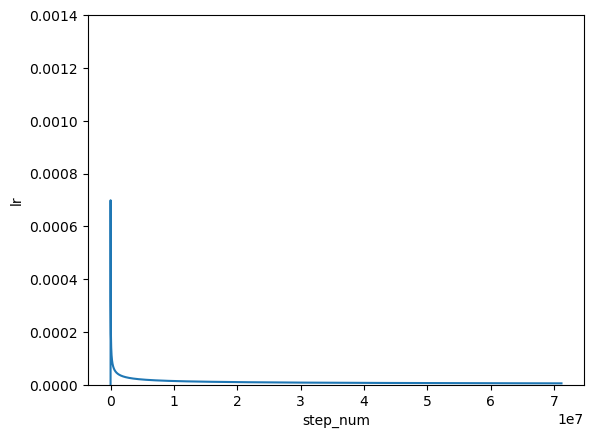

In [36]:
import numpy as np
import matplotlib.pyplot as plt

warmup_steps = 4000
num_steps_by_epoch = len(train_dataloader)
step_num = np.arange(1, EPOCHS*num_steps_by_epoch, 10)
step_num_exp = -0.5
warmup_steps_exp = -1.5
dim_embedding_exp = -0.5
lr = np.power(dim_embedding, dim_embedding_exp) * np.minimum(np.power(step_num, step_num_exp), step_num * np.power(warmup_steps, warmup_steps_exp))

plt.plot(step_num, lr)
plt.xlabel('step_num')
plt.ylabel('lr')
plt.ylim(0, 0.0014)
plt.show()

Como se puede ver sube muy rápido y luego baja muy rápido a un valor tan pequeño que es casi como si no hubiera learning rate. Por lo que los pesos de la red neuronal apenas se van a actualizar. Por lo que probando voy a usar esta fórmula

$$lr = d_{model}^{-0.1} \cdot min \left(stepNumber^{-0.4}, stepNumber \cdot stepWarmUp^{-2.6} \right)$$

Con lo que el learning rate evolucionaría así

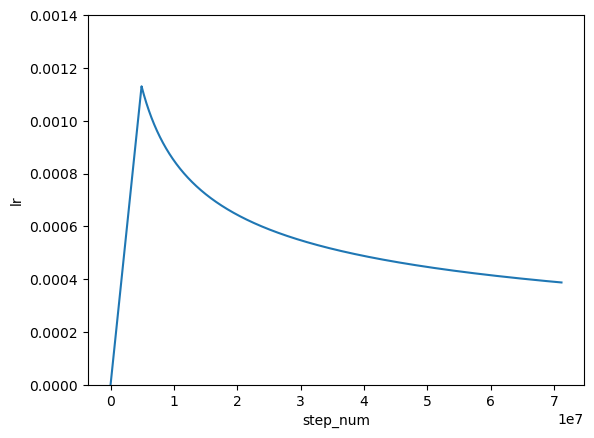

In [37]:
warmup_steps = 4000
num_steps_by_epoch = len(train_dataloader)
step_num = np.arange(1, EPOCHS*num_steps_by_epoch, 10)
step_num_exp = -0.4
warmup_steps_exp = -2.6
dim_embedding_exp = -0.1
lr = np.power(dim_embedding, dim_embedding_exp) * np.minimum(np.power(step_num, step_num_exp), step_num * np.power(warmup_steps, warmup_steps_exp))

plt.plot(step_num, lr)
plt.xlabel('step_num')
plt.ylabel('lr')
plt.ylim(0, 0.0014)
plt.show()

In [38]:
import numpy as np

def calculate_lr(step_num, dim_embeding_model=512, warmup_steps=4000):
    step_num += 1e-7 # Avoid division by zero
    step_num += STEP0
    actual_step.set_step(step_num)
    step_num_exp = -0.4
    warmup_steps_exp = -2.6
    dim_embeding_model_exp = -0.1
    lr = np.power(dim_embeding_model, dim_embeding_model_exp) * np.minimum(np.power(step_num, step_num_exp), step_num * np.power(warmup_steps, warmup_steps_exp))
    actual_lr.set_lr(lr)
    return lr

lr_lambda = lambda step: calculate_lr(step, dim_embeding_model=dim_embedding)
if LR_SCHEDULER:
    lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

### Validation loop ✔

In [39]:
def greedy_decode(model, source, tokenizer_tgt, max_len, device, bs):
    # Retrieving the indices from the start and end of sequences of the target tokens
    sos_idx = tokenizer_tgt.token_to_id('[SOS]')    # Start of Sentence token index (2)
    # eos_idx = tokenizer_tgt.token_to_id('[EOS]')    # End of Sentence token index (3)

    # Computing the output of the encoder for the source sequence
    encoder_output = model.encode(source)
    
    # Initializing the decoder input with the Start of Sentence token
    decoder_input = torch.empty(bs,1).fill_(sos_idx).type_as(source).to(device)
    
    # Looping until the 'max_len', maximum length, is reached
    while True:
        if decoder_input.size(1) == max_len:
            break
            
        # Building a mask for the decoder input
        decoder_mask = create_mask(decoder_input.size(1)).to(device)
        
        # Calculating the output of the decoder
        out = model.decode(encoder_output, decoder_input, decoder_mask)
        
        # Applying the projection layer to get the probabilities for the next token
        prob = model.projection(out[:, -1])

        # Selecting token with the highest probability
        _, next_word = torch.max(prob, dim=1)
        # decoder_input = torch.cat([decoder_input, torch.empty(1,1). type_as(source).fill_(next_word.item()).to(device)], dim=1)
        decoder_input = torch.cat([decoder_input, next_word.unsqueeze(1)], dim=1)
    
    if len(decoder_input.shape) == 1:
        decoder_input = decoder_input.unsqueeze(0)
    elif len(decoder_input.shape) == 3:
        decoder_input = decoder_input.squeeze(0)

    return decoder_input # Sequence of tokens generated by the decoder


In [40]:
from tqdm import tqdm

import nltk
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import meteor_score

def validation_loop(model, validation_ds, tokenizer_tgt, max_len, device):
    model.eval() # Setting model to evaluation mode

    # Calculating the number of batches in the validation dataset
    dataset_size = len(validation_ds.dataset)  # Tamaño total del conjunto de datos
    batch_size = validation_ds.batch_size      # Tamaño del batch
    drop_last = validation_ds.drop_last        # Configuración de drop_last
    num_batches = len(validation_ds)           # Número total de batches

    # Calculating the total number of samples in the validation dataset
    total_samples = batch_size * (num_batches - 1) + min(batch_size, dataset_size % batch_size)

    # If drop_last is False and the dataset size is not divisible by the batch size, we need to add one more batch
    if drop_last and dataset_size % batch_size != 0:
        total_samples -= dataset_size % batch_size

    # Initializing progress bar
    progress_bar = tqdm(range(total_samples), desc = 'Processing validation examples') # Initializing progress bar

    # Initializing lists to store scores
    bleu_scores = []
    meteor_scores = []
    
    # Creating evaluation loop
    with torch.no_grad(): # Ensuring that no gradients are computed during this process
        for batch in validation_ds:
            # Loading input data and masks onto the GPU
            encoder_input = batch['encoder_input'].to(device)
            
            # Applying the 'greedy_decode' function to get the model's output for the source text of the input batch
            num_samples = len(batch['src_text'])
            model_out_bs = greedy_decode(model, encoder_input, tokenizer_tgt, max_len, device, num_samples)

            # Get metrics for every example in the batch
            for i in range(num_samples):
                source_text = batch['src_text'][i]
                target_text = batch['tgt_text'][i]
                model_out_i = model_out_bs[i]
                model_out_text = tokenizer_tgt.decode(model_out_i.detach().cpu().numpy())

                # Calculating metrics
                references = [target_text.split()]
                hypothesis = model_out_text.split()
                bleu_score = sentence_bleu(references, hypothesis)
                meteor_score_value = meteor_score(references, hypothesis)
            
                # Appending scores to lists
                bleu_scores.append(bleu_score)
                meteor_scores.append(meteor_score_value)

                # Calculating mean scores            
                mean_bleu_score = sum(bleu_scores)/len(bleu_scores) # Calculating mean BLEU score
                mean_meteor_score = sum(meteor_scores)/len(meteor_scores) # Calculating mean METEOR score

                # Updating progress bar and printing bleu and meteor scores
                progress_bar.update(1)
                progress_bar.set_postfix({'BLEU': f'{mean_bleu_score:.9f}', 'METEOR': f'{mean_meteor_score:.9f}'})

    # Printing results
    console_width = 80 # Fixed witdh for printed messages
    print('-'*console_width)
    print(f'SOURCE: {source_text}')
    print(f'TARGET: {target_text}')
    print(f'PREDICTED: {model_out_text}')
    print('-'*console_width)

    return mean_bleu_score, mean_meteor_score


### Train loop ✔

In [41]:
def train_loop(model, train_dataloader, device, tokenizer_target, epoch, loss_fn, optimizer, lr_scheduler=None):
    # Initializing an iterator over the training dataloader
    # We also use tqdm to display a progress bar
    print()
    batch_iterator = tqdm(train_dataloader, desc = f'Processing epoch {epoch:02d}')
    
    # For each batch...
    for batch in batch_iterator:
        model.train() # Train the model
            
        # Loading input data and masks onto the GPU
        encoder_input = batch['encoder_input'].to(device)
        decoder_input = batch['decoder_input'].to(device)
        decoder_mask = create_mask(decoder_input.size(1)).to(device)
        
        # Running tensors through the Transformer
        proj_output = model(encoder_input, decoder_input, decoder_mask)
        
        # Loading the target labels onto the GPU
        label = batch['label'].to(device)
        
        # Computing loss between model's output and true labels
        loss = loss_fn(proj_output.view(-1, tokenizer_target.get_vocab_size()), label.view(-1))
        
        # Updating progress bar, print loss and lr
        batch_iterator.set_postfix({'loss': f'{loss.item():.6f}', 'lr': f'{actual_lr.get_lr():.9f}'})
        
        # Performing backpropagation
        loss.backward()
        
        # Updating parameters based on the gradients
        optimizer.step()
        
        # Clearing the gradients to prepare for the next batch
        optimizer.zero_grad()

        # Update step and LR
        if LR_SCHEDULER:
            lr_scheduler.step()
        
    return loss.item(), actual_lr.get_lr()

### Train

In [42]:
import time

def elapsed_time(t0):
    t = time.time() - t0  # tiempo transcurrido en segundos

    # Convertir el tiempo a días, horas, minutos y segundos
    days, t = divmod(t, 86400)  # 86400 segundos en un día
    hours, t = divmod(t, 3600)  # 3600 segundos en una hora
    minutes, seconds = divmod(t, 60)  # 60 segundos en un minuto

    return int(days), int(hours), int(minutes), int(seconds)

def elapsed_seconds(days, hours, minutes, seconds):
    return days * 86400 + hours * 3600 + minutes * 60 + seconds


In [43]:
if EPOCH0 != 0 or STEP0 != 0:
    weights = f"{MODEL_PATH}/transformer_{EPOCH0}_{STEP0}.pth"
    print(f"Loading model from {weights}")
    if GPUS > 1:
        model.load_state_dict(torch.load(weights))
    else:
        model = torch.load(weights, map_location=device)
        if isinstance(model, nn.DataParallel):
            print("Transforming model from data parallel to model")
            model = model.module
    print(f"Model loaded from {weights}")

    validation_file_path = f"{MODEL_PATH}/best_validation_bleu_{EPOCH0}_{STEP0}.npy"
    print(f"load best validation loss from {validation_file_path}")
    best_bleu = np.load(validation_file_path)
    print(f"best validation meteor: {best_bleu}")
else:
    best_bleu = 1e-20

print(f"Starting training from epoch {EPOCH0} and step {STEP0}, best bleu: {best_bleu}")


Starting training from epoch 0 and step 0, best bleu: 1e-20


In [44]:
train_loss_list = []
train_lr_list = []
validation_meteor_list = []
validation_bleu_list = []

train_loss_list = np.array(train_loss_list)
train_lr_list = np.array(train_lr_list)
validation_meteor_list = np.array(validation_meteor_list)
validation_bleu_list = np.array(validation_bleu_list)

In [45]:
from tqdm import tqdm

max_seconds = 60*60*11 + 60*30 # 11 horas y 30 minutos
t0 = time.time()

for epoch in range(0, EPOCHS):
    days, hours, minutes, seconds = elapsed_time(t0)
    print(f"\nEpoch {epoch}\n-------------------------------, {days} days, {hours} hours, {minutes} minutes, {seconds} seconds")

    # We run the 'train_loop' function at the beginning of each epoch
    if LR_SCHEDULER:
        train_loss, train_lr = train_loop(model, train_dataloader, device, tokenizer_target, epoch, loss_fn, optimizer, lr_scheduler)    
    else:
        train_loss, train_lr = train_loop(model, train_dataloader, device, tokenizer_target, epoch, loss_fn, optimizer)
        
    # We run the 'run_validation' function at the end of each epoch
    # to evaluate model performance
    validation_meteor, validation_bleu = validation_loop(model, validation_dataloader, tokenizer_target, max_sequence_len, device)

    train_loss_list = np.append(train_loss_list, train_loss)
    train_lr_list = np.append(train_lr_list, train_lr)
    validation_meteor_list = np.append(validation_meteor_list, validation_meteor)
    validation_bleu_list = np.append(validation_bleu_list, validation_bleu)

    if (validation_bleu > best_bleu) and SAVE_BEST_MODEL:
        best_bleu = validation_bleu
        weights = f"{MODEL_PATH}/transformer_{epoch}_{actual_step.get_step()}.pth"
        print(f"Saving model to {weights}")
        if GPUS > 1:
            torch.save(model.state_dict(), weights)
        else:
            torch.save(model, weights)
        print(f"Model saved to {weights}")

        best_bleu_path = f"{MODEL_PATH}/best_validation_bleu_{epoch}_{actual_step.get_step()}.npy"
        print(f"Saving best validation meteor to {best_bleu_path}")
        np.save(best_bleu_path, best_bleu)
        print(f"Best validation meteor saved to {best_bleu_path}")
    
    days, hours, minutes, seconds = elapsed_time(t0)
    if (elapsed_seconds(days, hours, minutes, seconds) > max_seconds) and STOP_AT_TIME:
        print(f"Elapsed time: {days} days, {hours} hours, {minutes} minutes, {seconds} seconds")
        break

print("Done")


Epoch 0
-------------------------------, 0 days, 0 hours, 0 minutes, 0 seconds



Processing epoch 00:   0%|          | 0/712 [00:00<?, ?it/s]

Processing validation examples:   0%|          | 0/1458 [00:00<?, ?it/s]/home/wallabot/miniforge3/envs/cursopytorch2/lib/python3.11/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/wallabot/miniforge3/envs/cursopytorch2/lib/python3.11/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/wallabot/miniforge3/envs/cursopytorch2/lib/python3.11/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the B

--------------------------------------------------------------------------------
SOURCE: - It's like you're speaking Brazilian.
TARGET: Como si hablaras en brasileño.
PREDICTED: - - que que que que .
--------------------------------------------------------------------------------

Epoch 1
-------------------------------, 0 days, 0 hours, 8 minutes, 23 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 433.03it/s, BLEU=0.000000000, METEOR=0.045590318]


--------------------------------------------------------------------------------
SOURCE: Sure. That's ashley kemp.
TARGET: Claro, es Ashley Kemp.
PREDICTED: . . . . . . . .
--------------------------------------------------------------------------------

Epoch 2
-------------------------------, 0 days, 0 hours, 16 minutes, 47 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 438.52it/s, BLEU=0.000000000, METEOR=0.056506392]


--------------------------------------------------------------------------------
SOURCE: Un grupo de viejos amigos vuelven a reunirse.
TARGET: Un grupo de viejos amigos vuelven a reunirse.
PREDICTED: de de de . . . . .
--------------------------------------------------------------------------------

Epoch 3
-------------------------------, 0 days, 0 hours, 25 minutes, 9 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 461.31it/s, BLEU=0.000000000, METEOR=0.067677070]


--------------------------------------------------------------------------------
SOURCE: Way over on the wet side
TARGET: En el lado húmedo
PREDICTED: en la la la la .
--------------------------------------------------------------------------------

Epoch 4
-------------------------------, 0 days, 0 hours, 33 minutes, 32 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 452.08it/s, BLEU=0.000311178, METEOR=0.086955792]


--------------------------------------------------------------------------------
SOURCE: Top hats and spats, old chum.
TARGET: Galeras y polainas, muchacho.
PREDICTED: y y . . . . . . . .
--------------------------------------------------------------------------------

Epoch 5
-------------------------------, 0 days, 0 hours, 41 minutes, 54 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 459.89it/s, BLEU=0.000000000, METEOR=0.097667100]


--------------------------------------------------------------------------------
SOURCE: Your sister seems to be way too short tempered.
TARGET: Tu hermana parece ser demasiado mal genio.
PREDICTED: Tu se se . . . . . . . .
--------------------------------------------------------------------------------

Epoch 6
-------------------------------, 0 days, 0 hours, 50 minutes, 17 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 427.05it/s, BLEU=0.000754660, METEOR=0.101971844]


--------------------------------------------------------------------------------
SOURCE: I am prepared to kill for you, and you say that I am not like you.
TARGET: Estoy dispuesto a matar por ti, y dices que no soy como tú.
PREDICTED: No me voy a mí a mí , y no me voy a mí . . .
--------------------------------------------------------------------------------

Epoch 7
-------------------------------, 0 days, 0 hours, 58 minutes, 40 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 451.57it/s, BLEU=0.001061199, METEOR=0.106163842]


--------------------------------------------------------------------------------
SOURCE: You know,you can't say that you weren't warned.
TARGET: Tu sabes, no puedes decir que no estabas advertida.
PREDICTED: No sabes que no te dije que no te . . . . .
--------------------------------------------------------------------------------

Epoch 8
-------------------------------, 0 days, 1 hours, 7 minutes, 2 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 451.59it/s, BLEU=0.001024475, METEOR=0.108909076]


--------------------------------------------------------------------------------
SOURCE: I am prepared to kill for you, and you say that I am not like you.
TARGET: Estoy dispuesto a matar por ti, y dices que no soy como tú.
PREDICTED: Te gusta que no te gusta a ti , y no soy un . . . .
--------------------------------------------------------------------------------

Epoch 9
-------------------------------, 0 days, 1 hours, 15 minutes, 24 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 444.97it/s, BLEU=0.001142605, METEOR=0.114409267]


--------------------------------------------------------------------------------
SOURCE: - Do you want to prevent her?
TARGET: ¿Quieres impedírselo? No.
PREDICTED: - ¿ Quieres que ? . . . . . . .
--------------------------------------------------------------------------------

Epoch 10
-------------------------------, 0 days, 1 hours, 23 minutes, 47 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 441.50it/s, BLEU=0.001521061, METEOR=0.118617279]


--------------------------------------------------------------------------------
SOURCE: (Parliament rejected the proposal)
TARGET: (El Parlamento rechaza la solicitud)
PREDICTED: ( El Comisión ( Parlamento ) ) ) ) ) ) ) )
--------------------------------------------------------------------------------

Epoch 11
-------------------------------, 0 days, 1 hours, 32 minutes, 9 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 453.23it/s, BLEU=0.002217385, METEOR=0.121752760]


--------------------------------------------------------------------------------
SOURCE: - Quite a factory you've got here.
TARGET: Vaya factoría que te has montado aquí.
PREDICTED: - Aquí tiene un aquí . . . . . . . .
--------------------------------------------------------------------------------

Epoch 12
-------------------------------, 0 days, 1 hours, 40 minutes, 32 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 448.05it/s, BLEU=0.002114262, METEOR=0.125007360]


--------------------------------------------------------------------------------
SOURCE: I'm just watching the pheromones ooze from your body.
TARGET: Estoy viendo las feromonas saliendo de tu cuerpo.
PREDICTED: Me el de tu . de tu . . . . .
--------------------------------------------------------------------------------

Epoch 13
-------------------------------, 0 days, 1 hours, 48 minutes, 54 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 456.47it/s, BLEU=0.002470066, METEOR=0.127758479]


--------------------------------------------------------------------------------
SOURCE: To my parents' till I get myself together.
TARGET: A la casa de mis padres, hasta que encuentre algo.
PREDICTED: Por Dios me a mis padres . . . . . .
--------------------------------------------------------------------------------

Epoch 14
-------------------------------, 0 days, 1 hours, 57 minutes, 16 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 449.29it/s, BLEU=0.002205229, METEOR=0.131500343]


--------------------------------------------------------------------------------
SOURCE: How's your baby?
TARGET: ¿Cómo está tu hijo?
PREDICTED: ¿ Cómo está tu bebé ? . . . . . . .
--------------------------------------------------------------------------------

Epoch 15
-------------------------------, 0 days, 2 hours, 5 minutes, 39 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 458.15it/s, BLEU=0.002656825, METEOR=0.132759307]


--------------------------------------------------------------------------------
SOURCE: I will not kill! Not even my enemies.
TARGET: Ni siquiera mis enemigos.
PREDICTED: No me a mis . . . . . . . .
--------------------------------------------------------------------------------

Epoch 16
-------------------------------, 0 days, 2 hours, 14 minutes, 1 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 448.72it/s, BLEU=0.003341822, METEOR=0.137717138]


--------------------------------------------------------------------------------
SOURCE: - When shall we know?
TARGET: - ¿Cuándo lo sabremos?
PREDICTED: - ¿ Cuándo lo sabemos ? . . . . . . .
--------------------------------------------------------------------------------

Epoch 17
-------------------------------, 0 days, 2 hours, 22 minutes, 24 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 453.81it/s, BLEU=0.003261939, METEOR=0.139135188]


--------------------------------------------------------------------------------
SOURCE: We know that Karen controls the Espheni defenses up and down the eastern seaboard.
TARGET: Sabemos que Karen controla las defensas Espheni en todo el tablero del este.
PREDICTED: Sabes que los en los y los del . . . .
--------------------------------------------------------------------------------

Epoch 18
-------------------------------, 0 days, 2 hours, 30 minutes, 47 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 452.65it/s, BLEU=0.003358601, METEOR=0.138522243]


--------------------------------------------------------------------------------
SOURCE: - Let's do this.Here you go.Let's go!
TARGET: Hagámoslo. Aquí tienes. ¡Vamos!
PREDICTED: - Vamos , vamos a hacer esto . . . . . . .
--------------------------------------------------------------------------------

Epoch 19
-------------------------------, 0 days, 2 hours, 39 minutes, 9 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 455.45it/s, BLEU=0.003751698, METEOR=0.143737876] 


--------------------------------------------------------------------------------
SOURCE: Subprogramme 2 Information services
TARGET: Subprograma 2 Servicios de información
PREDICTED: 2 de servicios de servicios
--------------------------------------------------------------------------------

Epoch 20
-------------------------------, 0 days, 2 hours, 47 minutes, 31 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 451.65it/s, BLEU=0.003251415, METEOR=0.145189107]


--------------------------------------------------------------------------------
SOURCE: Did you really see humans?
TARGET: ¿En realidad has visto humanos?
PREDICTED: ¿ Has visto los humanos ? . . . . . . .
--------------------------------------------------------------------------------

Epoch 21
-------------------------------, 0 days, 2 hours, 55 minutes, 54 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 448.12it/s, BLEU=0.004029970, METEOR=0.147195330]


--------------------------------------------------------------------------------
SOURCE: - no,no,jesus-- - no,I won't sign her death warrant.
TARGET: - No, no, Jesús... - No quiero firmar su sentencia de muerte.
PREDICTED: - No , no , no , no , no , no , no , no a la muerte .
--------------------------------------------------------------------------------

Epoch 22
-------------------------------, 0 days, 3 hours, 4 minutes, 17 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 443.78it/s, BLEU=0.003238016, METEOR=0.148255736]


--------------------------------------------------------------------------------
SOURCE: J'onn, are you--?
TARGET: ¿J'onn, estás...?
PREDICTED: , ¿ qué estás haciendo ? , ,
--------------------------------------------------------------------------------

Epoch 23
-------------------------------, 0 days, 3 hours, 12 minutes, 40 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 444.47it/s, BLEU=0.003247217, METEOR=0.151011651]


--------------------------------------------------------------------------------
SOURCE: Meeting like theives.
TARGET: De que nos veamos así, como ladrones.
PREDICTED: como . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 24
-------------------------------, 0 days, 3 hours, 21 minutes, 3 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 438.62it/s, BLEU=0.003962895, METEOR=0.153569831]


--------------------------------------------------------------------------------
SOURCE: - I earn my living!
TARGET: - ¡Me gano la vida!
PREDICTED: - ¡ Yo me ! . . . . . . .
--------------------------------------------------------------------------------

Epoch 25
-------------------------------, 0 days, 3 hours, 29 minutes, 26 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 444.45it/s, BLEU=0.003697189, METEOR=0.155334264]


--------------------------------------------------------------------------------
SOURCE: You know,you can't say that you weren't warned.
TARGET: Tu sabes, no puedes decir que no estabas advertida.
PREDICTED: Sabes , no sabes que no puedes decir que no lo dijiste . . . .
--------------------------------------------------------------------------------

Epoch 26
-------------------------------, 0 days, 3 hours, 37 minutes, 49 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 443.89it/s, BLEU=0.004455754, METEOR=0.156104549]


--------------------------------------------------------------------------------
SOURCE: I'm used to the way the children live at Downton, but it seems odd.
TARGET: Me acostumbré a cómo los niños viven en Downton, pero aún es extraño.
PREDICTED: Me gusta ser como los personas , pero me gusta ser en el pueblo . . .
--------------------------------------------------------------------------------

Epoch 27
-------------------------------, 0 days, 3 hours, 46 minutes, 12 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 458.33it/s, BLEU=0.005237675, METEOR=0.156582271]


--------------------------------------------------------------------------------
SOURCE: But that's fine. Is it?
TARGET: Pero está bien ¿no?
PREDICTED: Pero eso está bien . . . . . . . .
--------------------------------------------------------------------------------

Epoch 28
-------------------------------, 0 days, 3 hours, 54 minutes, 34 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 445.45it/s, BLEU=0.004925468, METEOR=0.156994193]


--------------------------------------------------------------------------------
SOURCE: Endless Summer, Local Boys.
TARGET: Verano Sin Fin, Muchachos Locales.
PREDICTED: , verano , . . . . . . . .
--------------------------------------------------------------------------------

Epoch 29
-------------------------------, 0 days, 4 hours, 2 minutes, 57 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 448.83it/s, BLEU=0.004946524, METEOR=0.160709783]


--------------------------------------------------------------------------------
SOURCE: Larry you can't keep on carrying a secret like that.
TARGET: Larry, ...no puedes algo así en secreto.
PREDICTED: No puedes que no puedes . . . . . . .
--------------------------------------------------------------------------------

Epoch 30
-------------------------------, 0 days, 4 hours, 11 minutes, 21 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 447.81it/s, BLEU=0.005791962, METEOR=0.157589257]


--------------------------------------------------------------------------------
SOURCE: There is a fraying link in Arthur's chain.
TARGET: Hay un eslabón a punto de partirse en la cadena de Arturo.
PREDICTED: Hay un de en el . . . . . .
--------------------------------------------------------------------------------

Epoch 31
-------------------------------, 0 days, 4 hours, 19 minutes, 44 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 452.11it/s, BLEU=0.006724168, METEOR=0.164106697]


--------------------------------------------------------------------------------
SOURCE: 8.5; communication No. 458/1991, Mukong v.
TARGET: 8.5; comunicación Nº 458/1991, Mukong c.
PREDICTED: 8 . 8 . 8 . 8 . 8 , párr . . . .
--------------------------------------------------------------------------------

Epoch 32
-------------------------------, 0 days, 4 hours, 28 minutes, 7 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 452.90it/s, BLEU=0.006632564, METEOR=0.165047515]


--------------------------------------------------------------------------------
SOURCE: We only became in love after she left.
TARGET: Nos enamoramos cuando ya se había ido.
PREDICTED: Sólo se cuando se . . . . . .
--------------------------------------------------------------------------------

Epoch 33
-------------------------------, 0 days, 4 hours, 36 minutes, 30 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 448.01it/s, BLEU=0.006155054, METEOR=0.164448308]


--------------------------------------------------------------------------------
SOURCE: (Announcer) They will be pushed to new heights...
TARGET: Serán empujado a nuevas alturas ...
PREDICTED: a ) los nuevos nuevos nuevos nuevos horas ; ... ... ... ... ...
--------------------------------------------------------------------------------

Epoch 34
-------------------------------, 0 days, 4 hours, 44 minutes, 52 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 452.80it/s, BLEU=0.006788060, METEOR=0.164054825]


--------------------------------------------------------------------------------
SOURCE: That is an inevitable reality - the question is 'when?'
TARGET: Esa es una realidad inevitable, la cuestión es cuándo.
PREDICTED: Es una gran historia de la causa de la causa de la historia , ¿ verdad ?
--------------------------------------------------------------------------------

Epoch 35
-------------------------------, 0 days, 4 hours, 53 minutes, 15 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 446.39it/s, BLEU=0.006411821, METEOR=0.164978338]


--------------------------------------------------------------------------------
SOURCE: No one has the right to make anyone swear it perhaps
TARGET: Nadie tiene el derecho de hacerle jurar a alguien algo así.
PREDICTED: Nadie debe haber hecho la que le a nadie . . . .
--------------------------------------------------------------------------------

Epoch 36
-------------------------------, 0 days, 5 hours, 1 minutes, 38 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 456.43it/s, BLEU=0.007052102, METEOR=0.162205001]


--------------------------------------------------------------------------------
SOURCE: I know you think that job wasn't right for me anyway.
TARGET: Ya sé que pensabas que ese trabajo no era el adecuado para mí.
PREDICTED: Sé que no sabía que es bueno para mí . de mí . . . .
--------------------------------------------------------------------------------

Epoch 37
-------------------------------, 0 days, 5 hours, 10 minutes, 1 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 463.50it/s, BLEU=0.006486387, METEOR=0.167642038]


--------------------------------------------------------------------------------
SOURCE: - That's a lot of work.
TARGET: - Es mucho trabajo.
PREDICTED: - Es mucho trabajo . . . . . . . .
--------------------------------------------------------------------------------

Epoch 38
-------------------------------, 0 days, 5 hours, 18 minutes, 24 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 446.20it/s, BLEU=0.006815084, METEOR=0.166508619]


--------------------------------------------------------------------------------
SOURCE: Perhaps we can use him in Las Vegas.
TARGET: Puede sernos útil en Las Vegas.
PREDICTED: Tal vez deberíamos ver a Las Vegas . . . . . . .
--------------------------------------------------------------------------------

Epoch 39
-------------------------------, 0 days, 5 hours, 26 minutes, 47 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 450.73it/s, BLEU=0.007971166, METEOR=0.170948917]


--------------------------------------------------------------------------------
SOURCE: He's got two pools. Who wouldn't marry him?
TARGET: Tiene dos piscinas, ¿quién no querría?
PREDICTED: ¿ Quién tiene dos ? . . . . . . .
--------------------------------------------------------------------------------

Epoch 40
-------------------------------, 0 days, 5 hours, 35 minutes, 9 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 442.78it/s, BLEU=0.007610489, METEOR=0.172035643]


--------------------------------------------------------------------------------
SOURCE: - The plane?
TARGET: ¿ - El avión?
PREDICTED: - ¿ El avión ? . . . . . . . .
--------------------------------------------------------------------------------

Epoch 41
-------------------------------, 0 days, 5 hours, 43 minutes, 32 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 436.21it/s, BLEU=0.007416143, METEOR=0.172869497]


--------------------------------------------------------------------------------
SOURCE: So I'm a liar?
TARGET: ¿Yo soy una mentirosa?
PREDICTED: ¿ Soy un mentiroso ? . . . . . . .
--------------------------------------------------------------------------------

Epoch 42
-------------------------------, 0 days, 5 hours, 51 minutes, 55 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 450.32it/s, BLEU=0.007503981, METEOR=0.172500971]


--------------------------------------------------------------------------------
SOURCE: (Parliament rejected the proposal)
TARGET: (El Parlamento rechaza la solicitud)
PREDICTED: ( El Parlamento aprueba la propuesta ) . de la propuesta de la propuesta de la propuesta ( propuesta
--------------------------------------------------------------------------------

Epoch 43
-------------------------------, 0 days, 6 hours, 0 minutes, 18 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 445.74it/s, BLEU=0.007742499, METEOR=0.174154865]


--------------------------------------------------------------------------------
SOURCE: - Earl, you'll wake the baby.
TARGET: - Earl, despertarás al bebé.
PREDICTED: - Earl , puedes ir al bebé . . . . . . .
--------------------------------------------------------------------------------

Epoch 44
-------------------------------, 0 days, 6 hours, 8 minutes, 40 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 439.73it/s, BLEU=0.007771963, METEOR=0.177113840]


--------------------------------------------------------------------------------
SOURCE: Come on, you must have something to say to me.
TARGET: Anda, algo tendrás que contarme.
PREDICTED: Vamos , tienes que tener que decirme algo . . . . . .
--------------------------------------------------------------------------------

Epoch 45
-------------------------------, 0 days, 6 hours, 17 minutes, 3 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 443.75it/s, BLEU=0.007918594, METEOR=0.175404772]


--------------------------------------------------------------------------------
SOURCE: Emergency rehearsal?
TARGET: ¿Ensayo urgente?
PREDICTED: ¿ El ensayo de emergencia ? . . de la estación de emergencia de emergencia . .
--------------------------------------------------------------------------------

Epoch 46
-------------------------------, 0 days, 6 hours, 25 minutes, 26 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 453.48it/s, BLEU=0.008394640, METEOR=0.178341989]


--------------------------------------------------------------------------------
SOURCE: Carla took this beautiful grouper and--and basically made chicken wings out of it.
TARGET: Carla tenía este hermoso mero y básicamente hizo alas de pollo con eso.
PREDICTED: una bolsa de y , y una bolsa de . . .
--------------------------------------------------------------------------------

Epoch 47
-------------------------------, 0 days, 6 hours, 33 minutes, 49 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 448.52it/s, BLEU=0.007980641, METEOR=0.180279534]


--------------------------------------------------------------------------------
SOURCE: I only have this one shot.
TARGET: solo tengo un disparo.
PREDICTED: Sólo tengo una oportunidad . . . . a uno . . .
--------------------------------------------------------------------------------

Epoch 48
-------------------------------, 0 days, 6 hours, 42 minutes, 12 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 453.98it/s, BLEU=0.007720820, METEOR=0.176948607]


--------------------------------------------------------------------------------
SOURCE: But Sasha was named National and World Team Coach.
TARGET: Perp Sasha fue nombrado entrenador nacional para los mundiales.
PREDICTED: - El Sr . fue un Sr . - . al Sr . . .
--------------------------------------------------------------------------------

Epoch 49
-------------------------------, 0 days, 6 hours, 50 minutes, 34 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 444.01it/s, BLEU=0.008438280, METEOR=0.179767798]


--------------------------------------------------------------------------------
SOURCE: And where are them little magnets I had over here, huh?
TARGET: ! Oh, ¡¿y dónde están los pequeños imanes que tenía por aquí, eh?
PREDICTED: Y aquí he estado aquí , ¿ dónde estaban los ? . . . .
--------------------------------------------------------------------------------

Epoch 50
-------------------------------, 0 days, 6 hours, 58 minutes, 57 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 451.42it/s, BLEU=0.008535130, METEOR=0.179773316]


--------------------------------------------------------------------------------
SOURCE: FORD Aspire car technical data.
TARGET: FORD Aspire datos técnicos de coches. Las especificaciones de coches.
PREDICTED: datos de coches . . de coches . . . .
--------------------------------------------------------------------------------

Epoch 51
-------------------------------, 0 days, 7 hours, 7 minutes, 20 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 438.22it/s, BLEU=0.008667760, METEOR=0.180287085]


--------------------------------------------------------------------------------
SOURCE: A soul eater?
TARGET: - ¿Come-almas?
PREDICTED: ¿ Un de ? . . . . . . .
--------------------------------------------------------------------------------

Epoch 52
-------------------------------, 0 days, 7 hours, 15 minutes, 43 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 453.22it/s, BLEU=0.008448142, METEOR=0.182393057]


--------------------------------------------------------------------------------
SOURCE: Michaelson, can you hear me?
TARGET: Michaelson, puedes escucharme?
PREDICTED: , ¿ me oyes ? . . . . . . .
--------------------------------------------------------------------------------

Epoch 53
-------------------------------, 0 days, 7 hours, 24 minutes, 6 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 450.38it/s, BLEU=0.009122156, METEOR=0.183634317]


--------------------------------------------------------------------------------
SOURCE: "sod all this, sod the queen, sod
TARGET: "a la mierda todo, a la mierda la reina, a la mierda...
PREDICTED: " , la reina de la reina , " . .
--------------------------------------------------------------------------------

Epoch 54
-------------------------------, 0 days, 7 hours, 32 minutes, 29 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 456.66it/s, BLEU=0.008444746, METEOR=0.183700683]


--------------------------------------------------------------------------------
SOURCE: You leave me no choice, Sefa.
TARGET: No me dejas opción, Sefa.
PREDICTED: No me , . . . . . . . .
--------------------------------------------------------------------------------

Epoch 55
-------------------------------, 0 days, 7 hours, 40 minutes, 52 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 445.82it/s, BLEU=0.008925025, METEOR=0.182388806]


--------------------------------------------------------------------------------
SOURCE: Whoa! That was crazy fast.
TARGET: - Eso sí que fue rápido.
PREDICTED: ¡ Eso fue una locura ! . . . . . . .
--------------------------------------------------------------------------------

Epoch 56
-------------------------------, 0 days, 7 hours, 49 minutes, 14 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 443.84it/s, BLEU=0.008608335, METEOR=0.184454005]


--------------------------------------------------------------------------------
SOURCE: - She's in my room.
TARGET: - Está en mi habitación.
PREDICTED: - Está en mi habitación . . . . . . . .
--------------------------------------------------------------------------------

Epoch 57
-------------------------------, 0 days, 7 hours, 57 minutes, 37 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 446.95it/s, BLEU=0.007980941, METEOR=0.184787648]


--------------------------------------------------------------------------------
SOURCE: The GPS data from Henry's car.
TARGET: La información del GPS del coche de Henry.
PREDICTED: Los datos del coche del coche del coche se . . . . .
--------------------------------------------------------------------------------

Epoch 58
-------------------------------, 0 days, 8 hours, 6 minutes, 0 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 447.64it/s, BLEU=0.008805389, METEOR=0.185413184]


--------------------------------------------------------------------------------
SOURCE: Those men over there will help you Emilka and I are going...
TARGET: Esos hombres de allí les ayudarán Emilka y yo vamos...
PREDICTED: Esos hombres están por ahí , y yo no te . . . .
--------------------------------------------------------------------------------

Epoch 59
-------------------------------, 0 days, 8 hours, 14 minutes, 22 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 442.25it/s, BLEU=0.008492373, METEOR=0.186662683]


--------------------------------------------------------------------------------
SOURCE: Man, it's a piece of cake, all right?
TARGET: Es muy fácil, Está bien?
PREDICTED: ¿ Qué es un pastel , no es un pastel ? . . . .
--------------------------------------------------------------------------------

Epoch 60
-------------------------------, 0 days, 8 hours, 22 minutes, 45 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 452.11it/s, BLEU=0.009109621, METEOR=0.185861220]


--------------------------------------------------------------------------------
SOURCE: Haven't I come...?
TARGET: ¿No he venido yo...?
PREDICTED: ¿ No he venido ...? . . . . . . .
--------------------------------------------------------------------------------

Epoch 61
-------------------------------, 0 days, 8 hours, 31 minutes, 8 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 455.50it/s, BLEU=0.009093141, METEOR=0.186642212]


--------------------------------------------------------------------------------
SOURCE: - Economic consequences.
TARGET: Consecuencias económicas.
PREDICTED: - Las consecuencias consecuencias . . . . . . . .
--------------------------------------------------------------------------------

Epoch 62
-------------------------------, 0 days, 8 hours, 39 minutes, 31 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 447.93it/s, BLEU=0.008824783, METEOR=0.187872786]


--------------------------------------------------------------------------------
SOURCE: I'll promote....
TARGET: Sólo promocionaré...
PREDICTED: Yo voy a ... ... ... ... ... ... ... ...
--------------------------------------------------------------------------------

Epoch 63
-------------------------------, 0 days, 8 hours, 47 minutes, 53 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 449.07it/s, BLEU=0.008725426, METEOR=0.187139357]


--------------------------------------------------------------------------------
SOURCE: - You look cold.
TARGET: - Parece que tienes frío.
PREDICTED: - Tienes frío . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 64
-------------------------------, 0 days, 8 hours, 56 minutes, 16 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 444.37it/s, BLEU=0.009460204, METEOR=0.190054595]


--------------------------------------------------------------------------------
SOURCE: Catherine. Hey!
TARGET: Catherine. ¡Oye!
PREDICTED: ¡ Catherine ! . . a Catherine . . a Catherine . . .
--------------------------------------------------------------------------------

Epoch 65
-------------------------------, 0 days, 9 hours, 4 minutes, 39 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 447.12it/s, BLEU=0.008973070, METEOR=0.189706869]


--------------------------------------------------------------------------------
SOURCE: He's using a lot of hot water.
TARGET: Utiliza un montón de agua caliente.
PREDICTED: Está caliente con agua caliente . . . . . . . .
--------------------------------------------------------------------------------

Epoch 66
-------------------------------, 0 days, 9 hours, 13 minutes, 1 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 445.22it/s, BLEU=0.009346535, METEOR=0.189160998]


--------------------------------------------------------------------------------
SOURCE: ♪ I'm gonna make you scream ooh!
TARGET: # ¡Te haré gritar! #
PREDICTED: ¡ Voy a gritar ! de puta ! de puta . . . .
--------------------------------------------------------------------------------

Epoch 67
-------------------------------, 0 days, 9 hours, 21 minutes, 23 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 453.31it/s, BLEU=0.008682699, METEOR=0.190231335]


--------------------------------------------------------------------------------
SOURCE: The allowance is paid out of the State budget by the State Social Insurance Fund.
TARGET: Estas prestaciones son imputables al Fondo de seguridad social (o al presupuesto del Estado).
PREDICTED: El Estado es el Estado jurídico de la Unión Europea para el Estado Estado del Estado . .
--------------------------------------------------------------------------------

Epoch 68
-------------------------------, 0 days, 9 hours, 29 minutes, 45 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 464.09it/s, BLEU=0.009809665, METEOR=0.190475237]


--------------------------------------------------------------------------------
SOURCE: Whoa! That was crazy fast.
TARGET: - Eso sí que fue rápido.
PREDICTED: ¡ Fue una locura loco ! . . . . . .
--------------------------------------------------------------------------------

Epoch 69
-------------------------------, 0 days, 9 hours, 38 minutes, 7 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 439.68it/s, BLEU=0.009620736, METEOR=0.188586366]


--------------------------------------------------------------------------------
SOURCE: Take all of it!
TARGET: ¡Tomen todo!
PREDICTED: ¡ todo ! . . . . . . .
--------------------------------------------------------------------------------

Epoch 70
-------------------------------, 0 days, 9 hours, 46 minutes, 29 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 453.66it/s, BLEU=0.009320903, METEOR=0.188748919]


--------------------------------------------------------------------------------
SOURCE: That's good, you got it.
TARGET: Muy bien, los tengo.
PREDICTED: Eso es bueno . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 71
-------------------------------, 0 days, 9 hours, 54 minutes, 51 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 448.79it/s, BLEU=0.008678497, METEOR=0.191756496]


--------------------------------------------------------------------------------
SOURCE: My father and his physical therapist, charming Daphne.
TARGET: Mi padre y su fisioterapeuta, la encantadora Daphne.
PREDICTED: Mi padre y su doctor de seguridad , el doctor y el doctor . . .
--------------------------------------------------------------------------------

Epoch 72
-------------------------------, 0 days, 10 hours, 3 minutes, 13 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 456.65it/s, BLEU=0.009200696, METEOR=0.190281813]


--------------------------------------------------------------------------------
SOURCE: "I'll fix it," he says.
TARGET: "La arreglaré", ha dicho.
PREDICTED: " Le digo que lo hará . . . . . . .
--------------------------------------------------------------------------------

Epoch 73
-------------------------------, 0 days, 10 hours, 11 minutes, 35 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 448.01it/s, BLEU=0.009536988, METEOR=0.190228440]


--------------------------------------------------------------------------------
SOURCE: Now, before you give us an answer, I want to impress you with three things.
TARGET: Antes de darnos una respuesta, quiero que sepa tres cosas.
PREDICTED: Ahora , antes de que , una pregunta antes de que . . .
--------------------------------------------------------------------------------

Epoch 74
-------------------------------, 0 days, 10 hours, 19 minutes, 57 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 448.31it/s, BLEU=0.008827963, METEOR=0.190314120]


--------------------------------------------------------------------------------
SOURCE: Well, that's all the time you got, Lopresti.
TARGET: Pues, eso es todo el tiempo que tienes, LoPresti.
PREDICTED: Bueno , todo el tiempo , te has tenido . . . . .
--------------------------------------------------------------------------------

Epoch 75
-------------------------------, 0 days, 10 hours, 28 minutes, 19 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 448.03it/s, BLEU=0.009128142, METEOR=0.189271594]


--------------------------------------------------------------------------------
SOURCE: ♪ I'm ready to drown
TARGET: *Estoy lista para ahogarme*
PREDICTED: * Estoy lista para #
--------------------------------------------------------------------------------

Epoch 76
-------------------------------, 0 days, 10 hours, 36 minutes, 41 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 435.86it/s, BLEU=0.009622467, METEOR=0.191539314]


--------------------------------------------------------------------------------
SOURCE: Conduct research on the financial costs and benefits of sustainability, and related investment products; and
TARGET: tealizar investigación sobre los costos y beneficios financieros de la sostenibilidad y los productos de inversión relacionados; y
PREDICTED: de beneficios en la comunicación de los beneficios y beneficios de las redes financieros y redes de inversión ;
--------------------------------------------------------------------------------

Epoch 77
-------------------------------, 0 days, 10 hours, 45 minutes, 3 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 448.12it/s, BLEU=0.009207228, METEOR=0.189635297]


--------------------------------------------------------------------------------
SOURCE: Number of visits: 4686
TARGET: Número de visitas: 1859
PREDICTED: Número de visitas : de visitas de visitas de visitas de visitas
--------------------------------------------------------------------------------

Epoch 78
-------------------------------, 0 days, 10 hours, 53 minutes, 26 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 448.74it/s, BLEU=0.008128180, METEOR=0.189983691]


--------------------------------------------------------------------------------
SOURCE: And if anyone asks, this is your savings account.
TARGET: Y si alguien pregunta, esta es su cuenta de ahorros.
PREDICTED: Y si esto es lo que alguien necesita , a sus ahorros . . . .
--------------------------------------------------------------------------------

Epoch 79
-------------------------------, 0 days, 11 hours, 1 minutes, 48 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 445.22it/s, BLEU=0.008956750, METEOR=0.193072044]


--------------------------------------------------------------------------------
SOURCE: How's your baby?
TARGET: ¿Cómo está tu hijo?
PREDICTED: ¿ Cómo está tu bebé ? . . . . . . .
--------------------------------------------------------------------------------

Epoch 80
-------------------------------, 0 days, 11 hours, 10 minutes, 10 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 446.79it/s, BLEU=0.009819047, METEOR=0.190588708]


--------------------------------------------------------------------------------
SOURCE: This is some sort of joke, right?
TARGET: Esta es una especie de broma, ¿verdad?
PREDICTED: Esto es una broma , ¿ no ? de broma . . . .
--------------------------------------------------------------------------------

Epoch 81
-------------------------------, 0 days, 11 hours, 18 minutes, 32 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 450.79it/s, BLEU=0.009684726, METEOR=0.192834784]


--------------------------------------------------------------------------------
SOURCE: Do you know also why he left me?
TARGET: ¿Sabe por qué me dejó?
PREDICTED: ¿ Sabes por qué me dejó ? por mí . . . . .
--------------------------------------------------------------------------------

Epoch 82
-------------------------------, 0 days, 11 hours, 26 minutes, 54 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 445.37it/s, BLEU=0.010098086, METEOR=0.192456229]


--------------------------------------------------------------------------------
SOURCE: Illawarra District, Australia, May 28, 2007.
TARGET: Distrito de Illawarra, Australia, 28 de mayo del 2007.
PREDICTED: 28 , 28 de mayo , 2007 , 28 de mayo . . . .
--------------------------------------------------------------------------------

Epoch 83
-------------------------------, 0 days, 11 hours, 35 minutes, 16 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 443.16it/s, BLEU=0.009572902, METEOR=0.193395747]


--------------------------------------------------------------------------------
SOURCE: It very much involves you, Denny, and you're not invited.
TARGET: Tu estas muy involucrado, Denny, y no estas invitado.
PREDICTED: Cuánto te , Jack , y no a ti . . . . .
--------------------------------------------------------------------------------

Epoch 84
-------------------------------, 0 days, 11 hours, 43 minutes, 38 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 442.49it/s, BLEU=0.009349463, METEOR=0.191396823]


--------------------------------------------------------------------------------
SOURCE: Did you spray the leuco-crystal violet in the lift? - Yes.
TARGET: ¿Creo que rociaste el leuco cristal violeta en el ascensor?
PREDICTED: ¿ el papel de - en la ? . . . .
--------------------------------------------------------------------------------

Epoch 85
-------------------------------, 0 days, 11 hours, 52 minutes, 0 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 446.60it/s, BLEU=0.010141470, METEOR=0.194013562]


--------------------------------------------------------------------------------
SOURCE: - A plea?
TARGET: - ¿Convenio de culpabilidad?
PREDICTED: - ¿ Un acuerdo ? . . . . a un acuerdo de acuerdo .
--------------------------------------------------------------------------------

Epoch 86
-------------------------------, 0 days, 12 hours, 0 minutes, 22 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 433.45it/s, BLEU=0.009262569, METEOR=0.192055668]


--------------------------------------------------------------------------------
SOURCE: How about a couple autographs?
TARGET: ¿Qué tal unos autógrafos?
PREDICTED: ¿ Qué tal un par de ? . . . . . .
--------------------------------------------------------------------------------

Epoch 87
-------------------------------, 0 days, 12 hours, 8 minutes, 44 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 447.94it/s, BLEU=0.009563356, METEOR=0.193153143]


--------------------------------------------------------------------------------
SOURCE: Yuriko told him that she wanted to go... but not necessarily with him.
TARGET: Yuriko le dijo que quería ir pero no necesariamente con él.
PREDICTED: dijo que no quería pero eso no quería saber . . con él . .
--------------------------------------------------------------------------------

Epoch 88
-------------------------------, 0 days, 12 hours, 17 minutes, 7 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 436.51it/s, BLEU=0.009241648, METEOR=0.194546957]


--------------------------------------------------------------------------------
SOURCE: Meeting like theives.
TARGET: De que nos veamos así, como ladrones.
PREDICTED: como el . como el . como el . . .
--------------------------------------------------------------------------------

Epoch 89
-------------------------------, 0 days, 12 hours, 25 minutes, 29 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 446.91it/s, BLEU=0.010764863, METEOR=0.195951871]


--------------------------------------------------------------------------------
SOURCE: I had a drink with an ex.
TARGET: Tomé un trago con un ex.
PREDICTED: Tuve un trago con una copa . con él . con un trago . . .
--------------------------------------------------------------------------------

Epoch 90
-------------------------------, 0 days, 12 hours, 33 minutes, 52 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 455.42it/s, BLEU=0.009368201, METEOR=0.193523648]


--------------------------------------------------------------------------------
SOURCE: - On Brecht.
TARGET: - sobre Brecht.
PREDICTED: - En . a . a . a . . .
--------------------------------------------------------------------------------

Epoch 91
-------------------------------, 0 days, 12 hours, 42 minutes, 14 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 447.92it/s, BLEU=0.009489132, METEOR=0.195469847]


--------------------------------------------------------------------------------
SOURCE: But if she's into it, I ain't over it.
TARGET: Pero le gusto, y no lo he superado.
PREDICTED: Pero si ella está en ella , no lo estoy . . . . .
--------------------------------------------------------------------------------

Epoch 92
-------------------------------, 0 days, 12 hours, 50 minutes, 37 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 436.05it/s, BLEU=0.010019349, METEOR=0.195569751]


--------------------------------------------------------------------------------
SOURCE: No, we're not zoned for this.
TARGET: No, no estamos en zonas para esto.
PREDICTED: No , no estamos para esto . . . . . .
--------------------------------------------------------------------------------

Epoch 93
-------------------------------, 0 days, 12 hours, 58 minutes, 59 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 458.79it/s, BLEU=0.010650467, METEOR=0.196938973]


--------------------------------------------------------------------------------
SOURCE: Watch and learn, Holmes.
TARGET: Mira y aprende, amigo.
PREDICTED: Mira , Holmes , . a su cabeza . . . . .
--------------------------------------------------------------------------------

Epoch 94
-------------------------------, 0 days, 13 hours, 7 minutes, 21 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 452.71it/s, BLEU=0.010778072, METEOR=0.196693900]


--------------------------------------------------------------------------------
SOURCE: The cosmic spores represented AIDS.
TARGET: Las esporas cósmicas, por supuesto, representan el SIDA.
PREDICTED: El autor se a la preocupación por los SIDA . en el SIDA . a la guerra
--------------------------------------------------------------------------------

Epoch 95
-------------------------------, 0 days, 13 hours, 15 minutes, 43 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 446.70it/s, BLEU=0.009990018, METEOR=0.197088037]


--------------------------------------------------------------------------------
SOURCE: Knowing that these young men that I handcuff and punish.
TARGET: Sabiendo que estos jóvenes que me esposan y castigan.
PREDICTED: Para que los hombres tanto que a este joven . . a los hombres .
--------------------------------------------------------------------------------

Epoch 96
-------------------------------, 0 days, 13 hours, 24 minutes, 5 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 462.05it/s, BLEU=0.010265306, METEOR=0.194931116]


--------------------------------------------------------------------------------
SOURCE: I really saw her climbing up the window
TARGET: Yo en realidad la vi trepando la ventana.
PREDICTED: Realmente vi la ventana de la ventana . a la ventana . a la ventana . .
--------------------------------------------------------------------------------

Epoch 97
-------------------------------, 0 days, 13 hours, 32 minutes, 26 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 441.74it/s, BLEU=0.009631258, METEOR=0.195988707]


--------------------------------------------------------------------------------
SOURCE: Why don't we go to Toulon?
TARGET: ¿Por qué no fuimos a Toulon?
PREDICTED: ¿ Por qué no vamos a ir a ? . . a . .
--------------------------------------------------------------------------------

Epoch 98
-------------------------------, 0 days, 13 hours, 40 minutes, 49 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 454.79it/s, BLEU=0.009694823, METEOR=0.194391377]


--------------------------------------------------------------------------------
SOURCE: You can only keep us from our work.
TARGET: Sólo nos interrumpirá nuestro trabajo.
PREDICTED: Puedes seguir nuestro trabajo . de trabajar . . . de trabajar . .
--------------------------------------------------------------------------------

Epoch 99
-------------------------------, 0 days, 13 hours, 49 minutes, 11 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 449.75it/s, BLEU=0.009782097, METEOR=0.195998191]


--------------------------------------------------------------------------------
SOURCE: If it helps to have me around, even for a little bit,
TARGET: Si ayuda tenerme cerca, aunque sea un poco,
PREDICTED: Si me ayuda , por un poco me hace ir ,
--------------------------------------------------------------------------------

Epoch 100
-------------------------------, 0 days, 13 hours, 57 minutes, 33 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 449.25it/s, BLEU=0.010651847, METEOR=0.194744464]


--------------------------------------------------------------------------------
SOURCE: - The plane?
TARGET: ¿ - El avión?
PREDICTED: - ¿ El avión ? . . . . en el avión . .
--------------------------------------------------------------------------------

Epoch 101
-------------------------------, 0 days, 14 hours, 5 minutes, 55 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 444.35it/s, BLEU=0.010308053, METEOR=0.196117566]


--------------------------------------------------------------------------------
SOURCE: Merck Sharp & Dohme Limited Hertford Road Hoddesdon Hertfordshire EN11 9BU United Kingdom
TARGET: Merck Sharp & Dohme Limited Hertford Road Hoddesdon Hertfordshire EN11 9BU Reino Unido
PREDICTED: & Limited Reino Unido Reino Unido
--------------------------------------------------------------------------------

Epoch 102
-------------------------------, 0 days, 14 hours, 14 minutes, 17 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 440.37it/s, BLEU=0.011141595, METEOR=0.196013310]


--------------------------------------------------------------------------------
SOURCE: - You can do it. CORDELIA:
TARGET: Puedes hacerlo.
PREDICTED: - Puedes hacerlo , . . . . . . . .
--------------------------------------------------------------------------------

Epoch 103
-------------------------------, 0 days, 14 hours, 22 minutes, 40 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 437.75it/s, BLEU=0.010614414, METEOR=0.194797386]


--------------------------------------------------------------------------------
SOURCE: There's this mate of mine.
TARGET: Ese amigo mío.
PREDICTED: Es mi mejor amigo . . de esta noche . . . . .
--------------------------------------------------------------------------------

Epoch 104
-------------------------------, 0 days, 14 hours, 31 minutes, 3 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 441.38it/s, BLEU=0.011577414, METEOR=0.196272515]


--------------------------------------------------------------------------------
SOURCE: Food and coffee. What time is it?
TARGET: Comida y café. ¿Qué hora es?
PREDICTED: El café y café , ¿ y qué es ? . . . .
--------------------------------------------------------------------------------

Epoch 105
-------------------------------, 0 days, 14 hours, 39 minutes, 25 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 442.62it/s, BLEU=0.011424700, METEOR=0.194915390]


--------------------------------------------------------------------------------
SOURCE: - Would he?
TARGET: ¿Lo haría?
PREDICTED: - ¿ Lo haría ? . . . . . . .
--------------------------------------------------------------------------------

Epoch 106
-------------------------------, 0 days, 14 hours, 47 minutes, 47 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 430.88it/s, BLEU=0.010214434, METEOR=0.195889523]


--------------------------------------------------------------------------------
SOURCE: Official medicine gave up on him.
TARGET: La medicina Oficial renunció a él.
PREDICTED: El oficial de le dio . a él . a él . en él .
--------------------------------------------------------------------------------

Epoch 107
-------------------------------, 0 days, 14 hours, 56 minutes, 9 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 449.93it/s, BLEU=0.011087728, METEOR=0.192889858]


--------------------------------------------------------------------------------
SOURCE: Ah, that's easy, Sal.
TARGET: Eso es fácil.
PREDICTED: Eso es fácil , Sal . . . . . . . .
--------------------------------------------------------------------------------

Epoch 108
-------------------------------, 0 days, 15 hours, 4 minutes, 31 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 439.78it/s, BLEU=0.009927766, METEOR=0.193957617]


--------------------------------------------------------------------------------
SOURCE: shall be grubbed up.
TARGET: serán arrancadas.
PREDICTED: Será . a la . . . . a la .
--------------------------------------------------------------------------------

Epoch 109
-------------------------------, 0 days, 15 hours, 12 minutes, 53 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 445.95it/s, BLEU=0.011159159, METEOR=0.192747601]


--------------------------------------------------------------------------------
SOURCE: What is this din? What's going on?
TARGET: ¿Qué es este escándalo, qué pasa?
PREDICTED: ¿ Qué está pasando ? . . a . a . de un
--------------------------------------------------------------------------------

Epoch 110
-------------------------------, 0 days, 15 hours, 21 minutes, 16 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 453.41it/s, BLEU=0.009128249, METEOR=0.194171013]


--------------------------------------------------------------------------------
SOURCE: It was just some stupid... fairy-tale rave.
TARGET: Sólo fue una estúpida... fiesta de cuentos de hadas.
PREDICTED: Fue una historia triste ... una de su . en un . de una
--------------------------------------------------------------------------------

Epoch 111
-------------------------------, 0 days, 15 hours, 29 minutes, 38 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 434.87it/s, BLEU=0.010636626, METEOR=0.195887748]


--------------------------------------------------------------------------------
SOURCE: Isn't that right, Seth?
TARGET: ¿No es así, Seth?
PREDICTED: ¿ No es tan Seth ? a las . . . a las .
--------------------------------------------------------------------------------

Epoch 112
-------------------------------, 0 days, 15 hours, 38 minutes, 0 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 455.66it/s, BLEU=0.009711229, METEOR=0.196069934]


--------------------------------------------------------------------------------
SOURCE: Ah, that's easy, Sal.
TARGET: Eso es fácil.
PREDICTED: Eso es fácil , Sal . . . . . . . .
--------------------------------------------------------------------------------

Epoch 113
-------------------------------, 0 days, 15 hours, 46 minutes, 21 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 447.97it/s, BLEU=0.011587951, METEOR=0.198197730]


--------------------------------------------------------------------------------
SOURCE: - Will you marry me? - No. - Can I ask you a favour?
TARGET: -¿Puedo pedirte un favor?
PREDICTED: - ¿ Me das un favor ? de . con esto . . . .
--------------------------------------------------------------------------------

Epoch 114
-------------------------------, 0 days, 15 hours, 54 minutes, 44 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 441.16it/s, BLEU=0.011855460, METEOR=0.197813281]


--------------------------------------------------------------------------------
SOURCE: Well an extraordinary story.
TARGET: Bueno, una historia extraordinaria.
PREDICTED: Bueno una historia extraordinario . . . . . . . .
--------------------------------------------------------------------------------

Epoch 115
-------------------------------, 0 days, 16 hours, 3 minutes, 6 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 455.65it/s, BLEU=0.011122329, METEOR=0.197524196]


--------------------------------------------------------------------------------
SOURCE: Well, the law says you have that right.
TARGET: Bueno, la ley dice que tienes ese derecho.
PREDICTED: Bueno , la ley dice que tienes razón . . . . . .
--------------------------------------------------------------------------------

Epoch 116
-------------------------------, 0 days, 16 hours, 11 minutes, 28 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 449.10it/s, BLEU=0.010711469, METEOR=0.193835704]


--------------------------------------------------------------------------------
SOURCE: The ghost is behind you!
TARGET: El fantasma está detrás de ti!
PREDICTED: ¡ El fantasma se vuelve ! . . . . . .
--------------------------------------------------------------------------------

Epoch 117
-------------------------------, 0 days, 16 hours, 19 minutes, 50 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 456.99it/s, BLEU=0.010481529, METEOR=0.196998871]


--------------------------------------------------------------------------------
SOURCE: She won't go to hospital.
TARGET: Ella no irá al hospital.
PREDICTED: No va a ir al hospital . a la escuela . a la escuela . .
--------------------------------------------------------------------------------

Epoch 118
-------------------------------, 0 days, 16 hours, 28 minutes, 12 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 449.70it/s, BLEU=0.010688040, METEOR=0.194939741]


--------------------------------------------------------------------------------
SOURCE: I'm going to go to Liverpool and discover The Beatles.
TARGET: Voy a ir a Liverpool y descubrir a Los Beatles.
PREDICTED: Voy a llamar a los Beatles . a los niños . a los niños . a los
--------------------------------------------------------------------------------

Epoch 119
-------------------------------, 0 days, 16 hours, 36 minutes, 34 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 444.40it/s, BLEU=0.011072256, METEOR=0.194860367]


--------------------------------------------------------------------------------
SOURCE: Just sign the fucking document.
TARGET: Firma el puto documento. Está bien.
PREDICTED: ¡ el documento ! al maldito documento . al maldito documento . . .
--------------------------------------------------------------------------------

Epoch 120
-------------------------------, 0 days, 16 hours, 44 minutes, 56 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 439.82it/s, BLEU=0.010664243, METEOR=0.195842683]


--------------------------------------------------------------------------------
SOURCE: He says, whoever talks will be swallowed up by the evil spirits of the rapids.
TARGET: Que quien hable será engullido por los espíritus malignos del remolino.
PREDICTED: Dice que que los sobre el silencio de los . a los .
--------------------------------------------------------------------------------

Epoch 121
-------------------------------, 0 days, 16 hours, 53 minutes, 18 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 466.10it/s, BLEU=0.010221049, METEOR=0.195937155]


--------------------------------------------------------------------------------
SOURCE: · The operational section of the CEP must be changed sufficiently to ensure its neutrality.
TARGET: · La sección de operaciones del CEP deberá ser suficientemente modificada a fin de asegurar su imparcialidad.
PREDICTED: · Para su funcionamiento y la debe ser necesario para su funcionamiento del funcionamiento del funcionamiento . .
--------------------------------------------------------------------------------

Epoch 122
-------------------------------, 0 days, 17 hours, 1 minutes, 40 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 447.49it/s, BLEU=0.010379372, METEOR=0.192909745]


--------------------------------------------------------------------------------
SOURCE: I just wanted to thank you for the rose.
TARGET: Sólo quería... darte las gracias por la rosa.
PREDICTED: Sólo quería darte las gracias por la gracias . . . por ti . .
--------------------------------------------------------------------------------

Epoch 123
-------------------------------, 0 days, 17 hours, 10 minutes, 2 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 428.80it/s, BLEU=0.009936728, METEOR=0.194167439]


--------------------------------------------------------------------------------
SOURCE: He's using a lot of hot water.
TARGET: Utiliza un montón de agua caliente.
PREDICTED: Está un poco caliente de agua . a un montón de agua . . . .
--------------------------------------------------------------------------------

Epoch 124
-------------------------------, 0 days, 17 hours, 18 minutes, 23 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 425.44it/s, BLEU=0.011887357, METEOR=0.195961524]


--------------------------------------------------------------------------------
SOURCE: The city of Breda was heavily fortified and defended by a garrison of 7,000 Dutch soldiers.
TARGET: La ciudad estaba fuertemente fortificada y defendida por una guarnición de 14.000 soldados.
PREDICTED: El de la ciudad fue de siete millones de y por los trabajadores de seguridad .
--------------------------------------------------------------------------------

Epoch 125
-------------------------------, 0 days, 17 hours, 26 minutes, 46 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 451.59it/s, BLEU=0.010626577, METEOR=0.193663074]


--------------------------------------------------------------------------------
SOURCE: James Lacey.
TARGET: James Lacey.
PREDICTED: Lacey Lacey . a Lacey . a Lacey . a Lacey . . .
--------------------------------------------------------------------------------

Epoch 126
-------------------------------, 0 days, 17 hours, 35 minutes, 8 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 448.91it/s, BLEU=0.010932651, METEOR=0.196380086]


--------------------------------------------------------------------------------
SOURCE: The song was mixed by Mark 'Spike' Stent.
TARGET: La canción fue mezclada por Mark 'Spike' Stent.
PREDICTED: La canción que estaba por Spike ' . en el anillo de Spike . .
--------------------------------------------------------------------------------

Epoch 127
-------------------------------, 0 days, 17 hours, 43 minutes, 30 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 459.72it/s, BLEU=0.010187167, METEOR=0.194113791]


--------------------------------------------------------------------------------
SOURCE: Only that night I drank my wine and as I recall...
TARGET: Sólo que esa noche yo bebí mi vino y me parece recordar que...
PREDICTED: Sólo quiero que mi vino y la noche que me ... y ... ... ...
--------------------------------------------------------------------------------

Epoch 128
-------------------------------, 0 days, 17 hours, 51 minutes, 52 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 450.36it/s, BLEU=0.011590106, METEOR=0.193661899]


--------------------------------------------------------------------------------
SOURCE: Haven't you ever heard of it?
TARGET: ¿No lo conoces?
PREDICTED: ¿ No has oído hablar de él ? de alguna vez . de alguna vez . .
--------------------------------------------------------------------------------

Epoch 129
-------------------------------, 0 days, 18 hours, 0 minutes, 14 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 439.04it/s, BLEU=0.011246288, METEOR=0.193521986]


--------------------------------------------------------------------------------
SOURCE: So a compromise was reached.
TARGET: Un compromiso fue alcanzado tan.
PREDICTED: Así que se ha ido a un compromiso . . a un acuerdo con nosotros . .
--------------------------------------------------------------------------------

Epoch 130
-------------------------------, 0 days, 18 hours, 8 minutes, 36 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 438.82it/s, BLEU=0.010405109, METEOR=0.193046379]


--------------------------------------------------------------------------------
SOURCE: - No.
TARGET: - No.
PREDICTED: - No . . a un poco de de vuelta . . .
--------------------------------------------------------------------------------

Epoch 131
-------------------------------, 0 days, 18 hours, 16 minutes, 58 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 441.46it/s, BLEU=0.010032116, METEOR=0.192844998]


--------------------------------------------------------------------------------
SOURCE: I'm not to wait on ladies, am I?
TARGET: - ¿Tendré que ocuparme de las señoras?
PREDICTED: - No estoy en las señoras , ¿ eh , señoras ? . . .
--------------------------------------------------------------------------------

Epoch 132
-------------------------------, 0 days, 18 hours, 25 minutes, 20 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 456.48it/s, BLEU=0.010772758, METEOR=0.192477738]


--------------------------------------------------------------------------------
SOURCE: well actually that was the conference at Copenhagen
TARGET: Bueno, de hecho fue en la conferencia de Copenhague.
PREDICTED: Bueno , en realidad era una reunión en Copenhague . en la ciudad . . .
--------------------------------------------------------------------------------

Epoch 133
-------------------------------, 0 days, 18 hours, 33 minutes, 43 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 441.35it/s, BLEU=0.010005039, METEOR=0.193073628]


--------------------------------------------------------------------------------
SOURCE: 07/046 of 12 June 2007 establishing the Border Police.
TARGET: 07/046, de 12 de junio de 2007, de creación de la Policía de Fronteras.
PREDICTED: 24 de junio de 2006 . 5 / 12 de junio de 2006
--------------------------------------------------------------------------------

Epoch 134
-------------------------------, 0 days, 18 hours, 42 minutes, 5 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 438.32it/s, BLEU=0.010986812, METEOR=0.194320402]


--------------------------------------------------------------------------------
SOURCE: I'm not spazzing out.
TARGET: No me volví loco.
PREDICTED: No estoy . a la . a la . a la .
--------------------------------------------------------------------------------

Epoch 135
-------------------------------, 0 days, 18 hours, 50 minutes, 27 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 456.68it/s, BLEU=0.011497791, METEOR=0.194282740]


--------------------------------------------------------------------------------
SOURCE: - I thought this was the bathroom.
TARGET: Pensé que éste era el baño.
PREDICTED: - Pensé que era el baño . . al baño del baño . . .
--------------------------------------------------------------------------------

Epoch 136
-------------------------------, 0 days, 18 hours, 58 minutes, 50 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 453.37it/s, BLEU=0.009855661, METEOR=0.194941129]


--------------------------------------------------------------------------------
SOURCE: All right, we'll deduct some time.
TARGET: Muy bien, vamos a deducir algún tiempo.
PREDICTED: Todo bien , nos un momento . en el tiempo . al otro momento . .
--------------------------------------------------------------------------------

Epoch 137
-------------------------------, 0 days, 19 hours, 7 minutes, 12 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 440.71it/s, BLEU=0.010580124, METEOR=0.191814609]


--------------------------------------------------------------------------------
SOURCE: The ministry of telecom awarded a mobile network operation contract to Egyptian Orascom
TARGET: El ministerio de telecomunicaciones premió con una operación de red móvil a la egipcia Orascom
PREDICTED: El usuario de esta operación le pidió una operación de alquiler de videos
--------------------------------------------------------------------------------

Epoch 138
-------------------------------, 0 days, 19 hours, 15 minutes, 34 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 439.18it/s, BLEU=0.009858385, METEOR=0.192551430]


--------------------------------------------------------------------------------
SOURCE: All the blood is the same type.
TARGET: Toda la sangre es del mismo tipo.
PREDICTED: Todo el mismo tipo de sangre es la misma . . . . .
--------------------------------------------------------------------------------

Epoch 139
-------------------------------, 0 days, 19 hours, 23 minutes, 56 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 442.02it/s, BLEU=0.011094212, METEOR=0.193682306]


--------------------------------------------------------------------------------
SOURCE: - My partner .
TARGET: - Mi compañera.
PREDICTED: - Mi socio . . . . . . de que .
--------------------------------------------------------------------------------

Epoch 140
-------------------------------, 0 days, 19 hours, 32 minutes, 19 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 442.28it/s, BLEU=0.011062782, METEOR=0.192538810]


--------------------------------------------------------------------------------
SOURCE: No one has the right to make anyone swear it perhaps
TARGET: Nadie tiene el derecho de hacerle jurar a alguien algo así.
PREDICTED: Nadie tiene que a nadie que lo haga . . . a él , .
--------------------------------------------------------------------------------

Epoch 141
-------------------------------, 0 days, 19 hours, 40 minutes, 41 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 449.82it/s, BLEU=0.009867302, METEOR=0.192235859]


--------------------------------------------------------------------------------
SOURCE: The car's not for sale, Suzanne.
TARGET: El auto no está en venta, Suzanne.
PREDICTED: La casa no es para Richard . . . . . . .
--------------------------------------------------------------------------------

Epoch 142
-------------------------------, 0 days, 19 hours, 49 minutes, 3 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 436.32it/s, BLEU=0.010768747, METEOR=0.195978563]


--------------------------------------------------------------------------------
SOURCE: And it's like I want to do something to help you.
TARGET: Es como que quiero hacer algo para ayudarte.
PREDICTED: Y es algo que quiero ayudarte . a algo como si fuera algo de lo que quiera . .
--------------------------------------------------------------------------------

Epoch 143
-------------------------------, 0 days, 19 hours, 57 minutes, 25 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 440.47it/s, BLEU=0.010105994, METEOR=0.190244493]


--------------------------------------------------------------------------------
SOURCE: Blue tag, in the new building, right behind us.
TARGET: Los de etiqueta azul, al nuevo edificio.
PREDICTED: en la computadora , justo detrás de nosotros . detrás . justo justo justo detrás .
--------------------------------------------------------------------------------

Epoch 144
-------------------------------, 0 days, 20 hours, 5 minutes, 47 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 444.15it/s, BLEU=0.009588125, METEOR=0.192576790]


--------------------------------------------------------------------------------
SOURCE: He's left the door open.
TARGET: Ha dejado la puerta abierta.
PREDICTED: Se ha ido a abrir la puerta . la puerta . a la puerta . . .
--------------------------------------------------------------------------------

Epoch 145
-------------------------------, 0 days, 20 hours, 14 minutes, 10 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 454.39it/s, BLEU=0.009977804, METEOR=0.190705626]


--------------------------------------------------------------------------------
SOURCE: It's a university.
TARGET: Es una universidad.
PREDICTED: Es una universidad . a la universidad . a la universidad . a la universidad .
--------------------------------------------------------------------------------

Epoch 146
-------------------------------, 0 days, 20 hours, 22 minutes, 32 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 417.74it/s, BLEU=0.010943908, METEOR=0.193892354]


--------------------------------------------------------------------------------
SOURCE: Just some trash.
TARGET: Solo basura.
PREDICTED: Sólo una basura . a un poco de basura . a algunos de los basura . .
--------------------------------------------------------------------------------

Epoch 147
-------------------------------, 0 days, 20 hours, 30 minutes, 54 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 442.32it/s, BLEU=0.009650355, METEOR=0.191668507]


--------------------------------------------------------------------------------
SOURCE: - Yes, sir! - Mr. Secretary?
TARGET: ¿Sr. Secretario?
PREDICTED: - ¿ Señor Secretario dólares ? . , señor . . , señor . .
--------------------------------------------------------------------------------

Epoch 148
-------------------------------, 0 days, 20 hours, 39 minutes, 17 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 439.23it/s, BLEU=0.011599211, METEOR=0.192240414]


--------------------------------------------------------------------------------
SOURCE: Did you talk to your folks?
TARGET: ¿Hablaste con tus padres?
PREDICTED: ¿ a tu familia ? a hablar con ella . a tu familia . .
--------------------------------------------------------------------------------

Epoch 149
-------------------------------, 0 days, 20 hours, 47 minutes, 39 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 442.87it/s, BLEU=0.010447649, METEOR=0.190840587]


--------------------------------------------------------------------------------
SOURCE: Let's go, Big.
TARGET: Vamos, Gordo.
PREDICTED: Vamos , Big . . . . . . . . .
--------------------------------------------------------------------------------

Epoch 150
-------------------------------, 0 days, 20 hours, 56 minutes, 1 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 450.11it/s, BLEU=0.009133076, METEOR=0.189515971]


--------------------------------------------------------------------------------
SOURCE: - I earn my living!
TARGET: - ¡Me gano la vida!
PREDICTED: ¡ Yo vivo mi vida ! en mi vida . . . . .
--------------------------------------------------------------------------------

Epoch 151
-------------------------------, 0 days, 21 hours, 4 minutes, 22 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 446.62it/s, BLEU=0.010266932, METEOR=0.192970785]


--------------------------------------------------------------------------------
SOURCE: Vinny's like, you know, I really wanna go in the jacuzzi.
TARGET: Vinny estaba como, de verdad quiero ir al jacuzzi.
PREDICTED: , me parece que realmente quieres estar en el . en el lugar de verdad .
--------------------------------------------------------------------------------

Epoch 152
-------------------------------, 0 days, 21 hours, 12 minutes, 45 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 436.77it/s, BLEU=0.010249481, METEOR=0.189166138]


--------------------------------------------------------------------------------
SOURCE: - Is Amy joining us today?
TARGET: ¿Amy nos acompañará hoy?
PREDICTED: - ¿ Hoy hoy se va con Amy ? . . . . hoy
--------------------------------------------------------------------------------

Epoch 153
-------------------------------, 0 days, 21 hours, 21 minutes, 7 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 439.58it/s, BLEU=0.010039808, METEOR=0.191578390]


--------------------------------------------------------------------------------
SOURCE: That's good, you got it.
TARGET: Muy bien, los tengo.
PREDICTED: Eso es bueno , lo tienes . . . . . en tu vida .
--------------------------------------------------------------------------------

Epoch 154
-------------------------------, 0 days, 21 hours, 29 minutes, 29 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 433.73it/s, BLEU=0.010298298, METEOR=0.190493721]


--------------------------------------------------------------------------------
SOURCE: - I released my own single, if that's a waste.
TARGET: - Saqué mi propio single, si eso es malo.
PREDICTED: - Yo también lo . a mi propia mina . a mi propio tiempo . .
--------------------------------------------------------------------------------

Epoch 155
-------------------------------, 0 days, 21 hours, 37 minutes, 50 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 441.25it/s, BLEU=0.009731471, METEOR=0.193370284]


--------------------------------------------------------------------------------
SOURCE: - Michael, - sometimes...
TARGET: - ...a veces...
PREDICTED: - Michael , a veces ... a la noche . a veces . a la noche .
--------------------------------------------------------------------------------

Epoch 156
-------------------------------, 0 days, 21 hours, 46 minutes, 12 seconds



Processing validation examples: 100%|██████████| 1458/1458 [00:03<00:00, 433.64it/s, BLEU=0.009867412, METEOR=0.192398339]


--------------------------------------------------------------------------------
SOURCE: So a compromise was reached.
TARGET: Un compromiso fue alcanzado tan.
PREDICTED: Entonces fue un compromiso con nosotros . a un acuerdo . a la cárcel . .
--------------------------------------------------------------------------------

Epoch 157
-------------------------------, 0 days, 21 hours, 54 minutes, 35 seconds



Processing epoch 157:  92%|█████████▏| 652/712 [07:37<00:42,  1.42it/s, loss=2.794640, lr=0.000000000]


KeyboardInterrupt: 

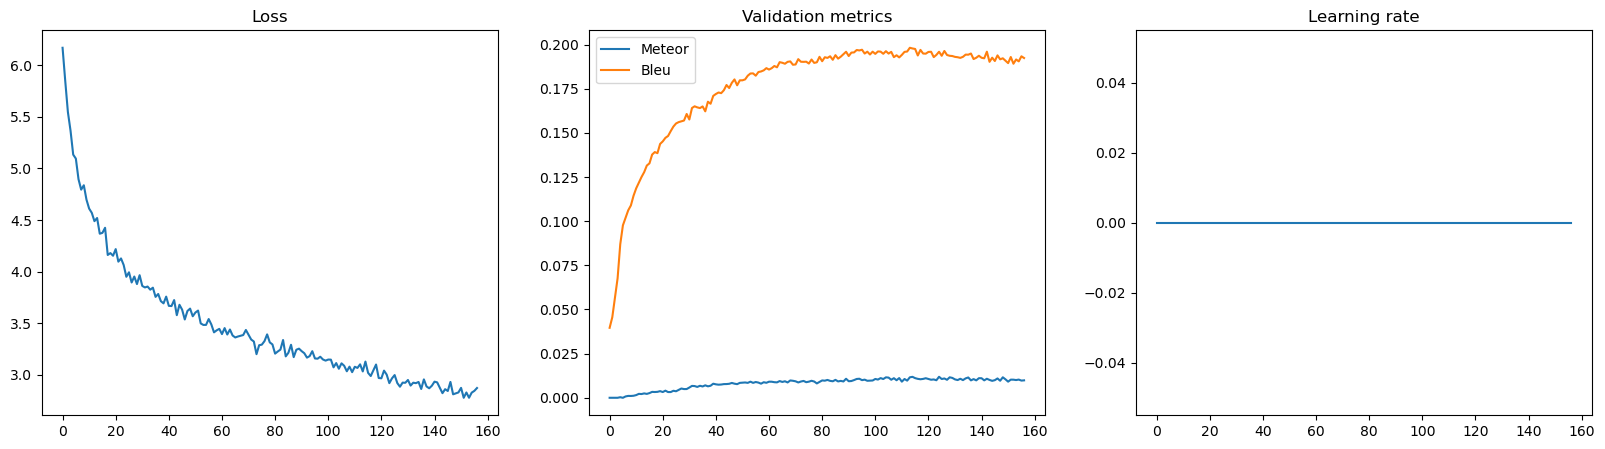

In [46]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(20, 5))
axs[0].plot(train_loss_list)
axs[0].set_title("Loss")
axs[1].plot(validation_meteor_list)
axs[1].plot(validation_bleu_list)
axs[1].legend(["Meteor", "Bleu"])
axs[1].set_title("Validation metrics")
axs[2].plot(train_lr_list)
axs[2].set_title("Learning rate")
plt.show()